In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

import time

from jax import numpy as jnp
from jax import random as jr
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
# import tensorflow as tf
# tf.test.gpu_device_name()

import gaussfiltax.utils as utils
import gaussfiltax.inference as gf
from gaussfiltax.inference import ParamsUKF, _ukf_predict_nonadditive
from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF
from gaussfiltax.containers import num_prt1, num_prt2


import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Parameters
state_dim = 4
state_noise_dim = 2
emission_dim = 2
emission_noise_dim = 2
seq_length = 30
mu0 = 1.0 * jnp.array([-0.05, 0.001, 0.7, -0.05])
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.zeros(emission_noise_dim)
Sigma0 = 1.0 * jnp.array([[0.1, 0.0, 0.0, 0.0],[0.0, 0.005, 0.0, 0.0],[0.0, 0.0, 0.1, 0.0],[0.0, 0.0, 0.0, 0.01]])
Q = 1e-6 * jnp.eye(state_noise_dim)
R = 25*1e-6 * jnp.eye(emission_noise_dim)

dt = 0.5
FCV = jnp.array([[1, dt, 0, 0],[0, 1, 0, 0],[0, 0, 1, dt],[0, 0, 0, 1]])
acc = 0.5
Omega = lambda x, acc: 0.1 * acc / jnp.sqrt(x[1]**2 + x[3]**2)
FCT =  lambda x, a: jnp.array([[1, jnp.sin(dt * Omega(x, a)) / Omega(x, a), 0, -(1-jnp.cos(dt * Omega(x, a))) / Omega(x, a)],
                            [0, jnp.cos(dt * Omega(x, a)), 0, -jnp.sin(dt * Omega(x, a))],
                            [0, (1-jnp.cos(dt * Omega(x, a))) / Omega(x, a), 1, jnp.sin(dt * Omega(x, a)) / Omega(x, a)],
                            [0, jnp.sin(dt * Omega(x, a)), 0, jnp.cos(dt * Omega(x, a))]])

G = jnp.array([[0.5, 0],[1, 0],[0, 0.5],[0, 1]])
fBOT = lambda x, q, u: FCV @ x + G @ q
fManBOT = lambda x, q, u: (0.5*(u-1)*(u-2)*FCV - u*(u-2)*FCT(x, acc) + 0.5*u*(u-1) * FCT(x, -acc)) @ x + G @ q
gBOT = lambda x, r, u: jnp.arctan2(x[2], x[0]) + r
gBOT2 = lambda x ,r, u: jnp.array([jnp.arctan2(x[2], x[0]), jnp.sqrt(x[0]**2 + x[2]**2)]) + r
gBOTlp = lambda x, y, u: MVN(loc = gBOT2(x, r0, u), covariance_matrix = R).log_prob(y)
# inputs = jnp.zeros((seq_length, 1))
inputs = jnp.array([1]*int(seq_length/3) + [0]*int(seq_length/3) + [2]*int(seq_length/3)) # maneuver inputs

In [3]:
f = fManBOT
g = gBOT2
glp = gBOTlp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

## Experiments

sim 1/100
key0:  [3568232559  713140391]
key:  [3620866055 2761185182]
       Time taken for GSF:  1.0908191204071045
       Time taken for UGSF:  1.0493826866149902
       Time taken for AGSF:  6.887598752975464
       Time taken for UAGSF:  7.000025033950806
       Time taken for BPF:  3.440580129623413
              GSF RMSE: 0.017952953
              UGSF RMSE: 0.034901038
              AGSF RMSE: 0.05740271
              UAGSF RMSE: 0.050948933
              BPF RMSE: 0.0053449525


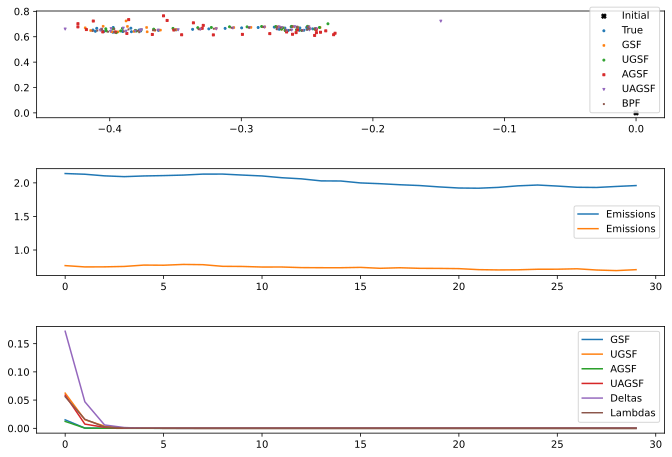

sim 2/100
key0:  [1465327881 3584627995]
key:  [1697684642 2171187924]
       Time taken for GSF:  1.102240800857544
       Time taken for UGSF:  0.983008861541748
       Time taken for AGSF:  6.7562339305877686
       Time taken for UAGSF:  7.166553258895874
       Time taken for BPF:  3.3781981468200684
              GSF RMSE: 0.01760818
              UGSF RMSE: 0.03398804
              AGSF RMSE: 0.009242382
              UAGSF RMSE: 0.03153832
              BPF RMSE: 0.0049907602


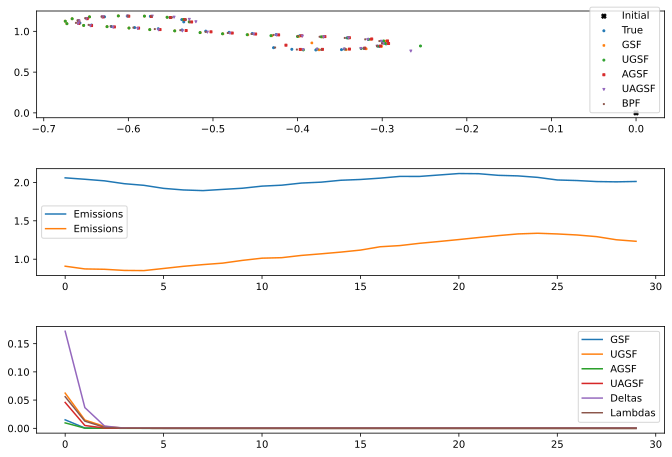

sim 3/100
key0:  [2140591709 3509555027]
key:  [704465164 725215309]
       Time taken for GSF:  0.9327659606933594
       Time taken for UGSF:  0.9613518714904785
       Time taken for AGSF:  6.751798868179321
       Time taken for UAGSF:  7.052167892456055
       Time taken for BPF:  3.4416792392730713
              GSF RMSE: 0.022475505
              UGSF RMSE: 0.013284731
              AGSF RMSE: 0.024496015
              UAGSF RMSE: 0.009488603
              BPF RMSE: 0.004345097


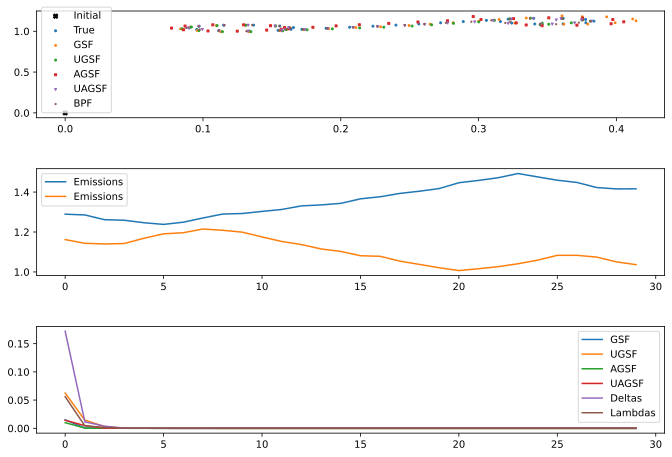

sim 4/100
key0:  [1303716432 1855432450]
key:  [2242020428 1473874242]
       Time taken for GSF:  0.8368220329284668
       Time taken for UGSF:  1.095719814300537
       Time taken for AGSF:  6.688279151916504
       Time taken for UAGSF:  7.383447885513306
       Time taken for BPF:  3.4048120975494385
              GSF RMSE: 0.014560955
              UGSF RMSE: 0.021563431
              AGSF RMSE: 0.0069037555
              UAGSF RMSE: 0.008513701
              BPF RMSE: 0.018465472


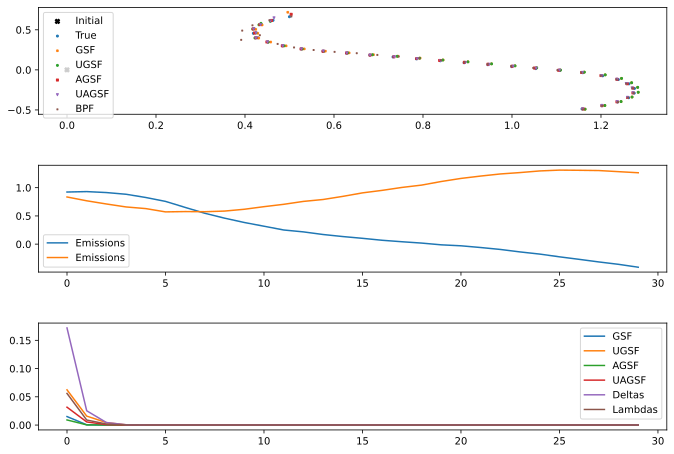

sim 5/100
key0:  [3538396939 1919323064]
key:  [ 339212260 4043306578]
       Time taken for GSF:  1.002115249633789
       Time taken for UGSF:  0.9219319820404053
       Time taken for AGSF:  6.694282054901123
       Time taken for UAGSF:  7.05214786529541
       Time taken for BPF:  3.4165477752685547
              GSF RMSE: 0.012735314
              UGSF RMSE: 0.018532364
              AGSF RMSE: 0.010845757
              UAGSF RMSE: 0.010751341
              BPF RMSE: 0.012286517


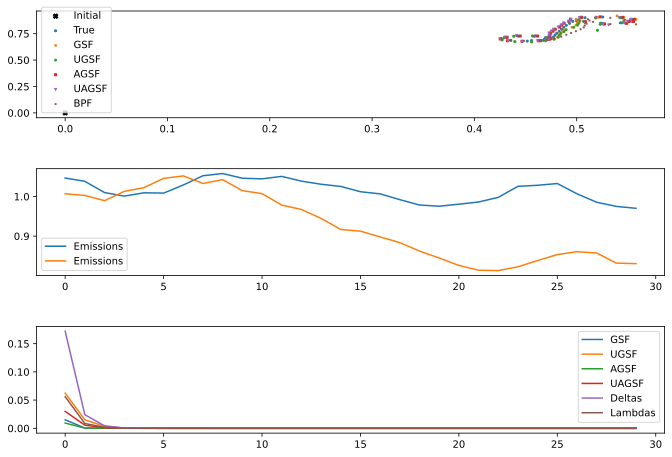

sim 6/100
key0:  [1897248577 2211687077]
key:  [2260205803 3719488220]
       Time taken for GSF:  0.8075399398803711
       Time taken for UGSF:  0.9172909259796143
       Time taken for AGSF:  6.645621061325073
       Time taken for UAGSF:  6.953856945037842
       Time taken for BPF:  3.1725120544433594
              GSF RMSE: 0.015097154
              UGSF RMSE: 0.023565767
              AGSF RMSE: 0.009194148
              UAGSF RMSE: 0.017516421
              BPF RMSE: 0.004142511


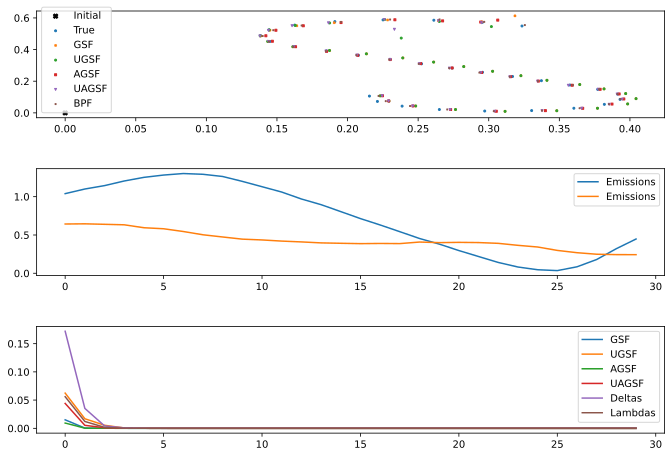

sim 7/100
key0:  [3004561477  573555509]
key:  [1598224098 3185611331]
       Time taken for GSF:  1.038818120956421
       Time taken for UGSF:  0.9114518165588379
       Time taken for AGSF:  6.6851582527160645
       Time taken for UAGSF:  7.033772230148315
       Time taken for BPF:  3.1684510707855225
              GSF RMSE: 0.012562874
              UGSF RMSE: 0.023416871
              AGSF RMSE: 0.009685443
              UAGSF RMSE: 0.016237363
              BPF RMSE: 0.0062350794


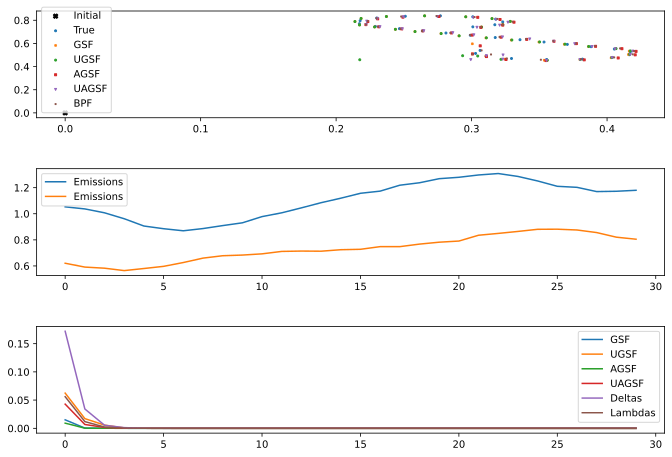

sim 8/100
key0:  [1641975508 2801076567]
key:  [ 858213663 2181881252]
       Time taken for GSF:  0.8108811378479004
       Time taken for UGSF:  0.9042999744415283
       Time taken for AGSF:  6.708536148071289
       Time taken for UAGSF:  7.105900049209595
       Time taken for BPF:  3.2185962200164795
              GSF RMSE: 0.019790191
              UGSF RMSE: 0.03735054
              AGSF RMSE: 0.015410117
              UAGSF RMSE: 0.03607899
              BPF RMSE: 0.021821385


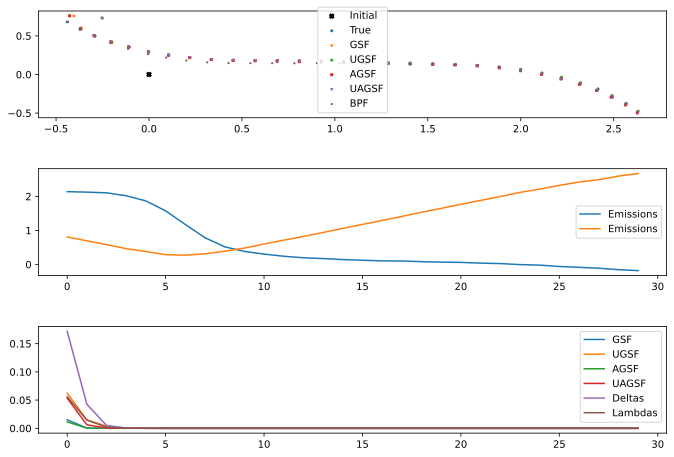

sim 9/100
key0:  [2964592761 3963767653]
key:  [1703955756 4117464756]
       Time taken for GSF:  0.8173151016235352
       Time taken for UGSF:  1.2339160442352295
       Time taken for AGSF:  6.503316879272461
       Time taken for UAGSF:  7.0440168380737305
       Time taken for BPF:  3.1673898696899414
              GSF RMSE: 0.037579298
              UGSF RMSE: 0.051956445
              AGSF RMSE: 0.058397893
              UAGSF RMSE: 0.07563741
              BPF RMSE: 0.0063275862


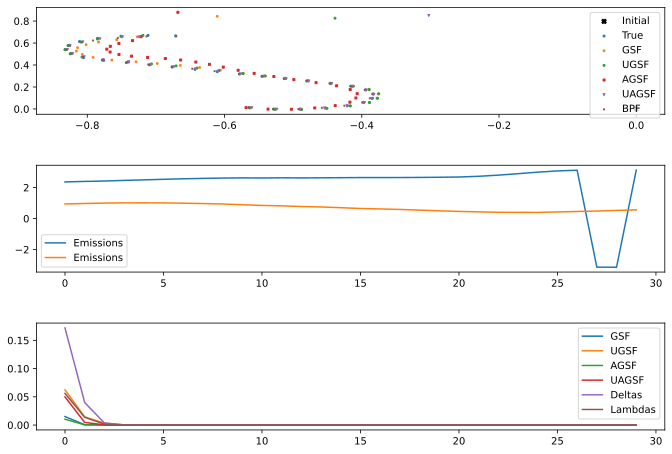

sim 10/100
key0:  [ 750034854 1626364709]
key:  [2376732689 1821473027]
       Time taken for GSF:  0.8202579021453857
       Time taken for UGSF:  1.2763819694519043
       Time taken for AGSF:  6.602765083312988
       Time taken for UAGSF:  7.614780902862549
       Time taken for BPF:  3.398137092590332
              GSF RMSE: nan
              UGSF RMSE: 0.09006851
              AGSF RMSE: 0.07386457
              UAGSF RMSE: 0.070822865
              BPF RMSE: 0.009924079


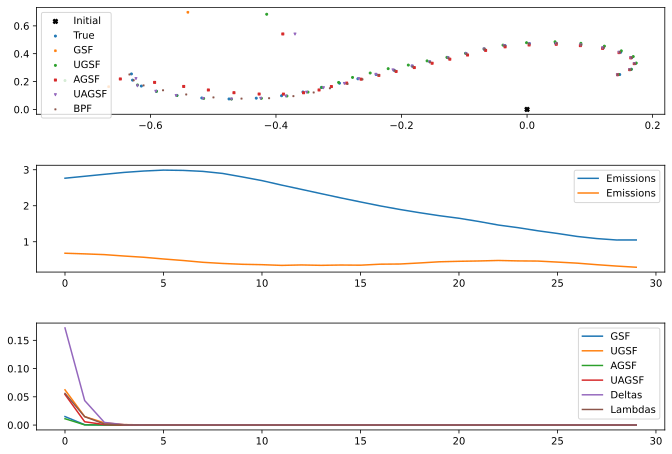

sim 11/100
key0:  [2473269265 1930548377]
key:  [1355056684 1763165466]
       Time taken for GSF:  0.8494539260864258
       Time taken for UGSF:  0.9341130256652832
       Time taken for AGSF:  6.989012002944946
       Time taken for UAGSF:  7.6346259117126465
       Time taken for BPF:  3.3952219486236572
              GSF RMSE: nan
              UGSF RMSE: 0.030280655
              AGSF RMSE: 0.07014615
              UAGSF RMSE: 0.016271109
              BPF RMSE: 0.017153451


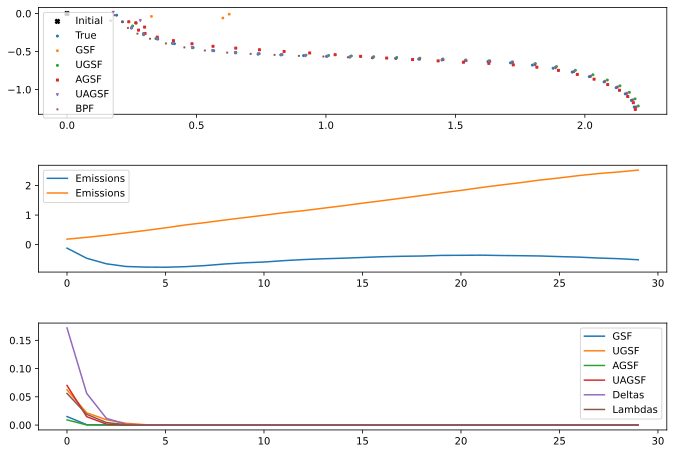

sim 12/100
key0:  [2242128751 2689217281]
key:  [3601313016  705004009]
       Time taken for GSF:  0.8170380592346191
       Time taken for UGSF:  0.9505581855773926
       Time taken for AGSF:  6.889410972595215
       Time taken for UAGSF:  6.675734996795654
       Time taken for BPF:  3.2690377235412598
              GSF RMSE: 0.017847218
              UGSF RMSE: 0.022267427
              AGSF RMSE: 0.008554651
              UAGSF RMSE: 0.025151335
              BPF RMSE: 0.005036598


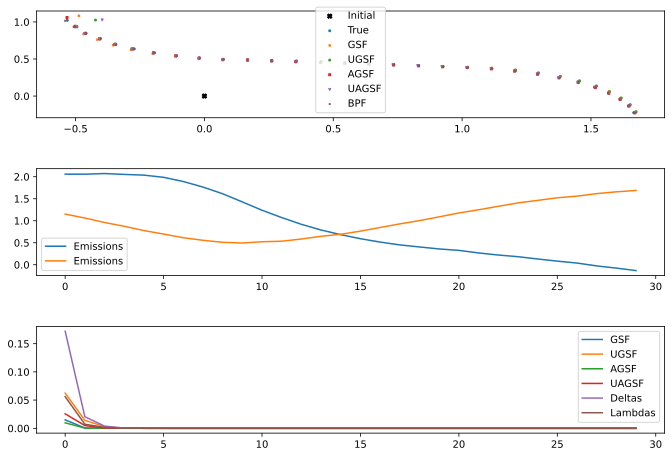

sim 13/100
key0:  [581586835 330633787]
key:  [3784394595 4044246026]
       Time taken for GSF:  0.9402039051055908
       Time taken for UGSF:  1.356658935546875
       Time taken for AGSF:  6.387713193893433
       Time taken for UAGSF:  7.213106155395508
       Time taken for BPF:  3.2800049781799316
              GSF RMSE: 0.018714696
              UGSF RMSE: 0.016183818
              AGSF RMSE: 0.0077106645
              UAGSF RMSE: 0.011132801
              BPF RMSE: 0.0062955054


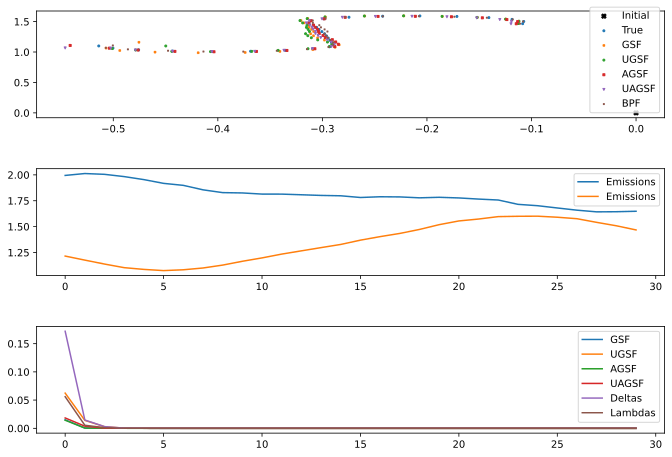

sim 14/100
key0:  [488089718 318464779]
key:  [ 979764689 1026999993]
       Time taken for GSF:  0.8313400745391846
       Time taken for UGSF:  0.9233322143554688
       Time taken for AGSF:  6.861353874206543
       Time taken for UAGSF:  6.772846698760986
       Time taken for BPF:  3.2553839683532715
              GSF RMSE: 0.011914578
              UGSF RMSE: 0.026097406
              AGSF RMSE: 0.013341295
              UAGSF RMSE: 0.01348956
              BPF RMSE: 0.011038965


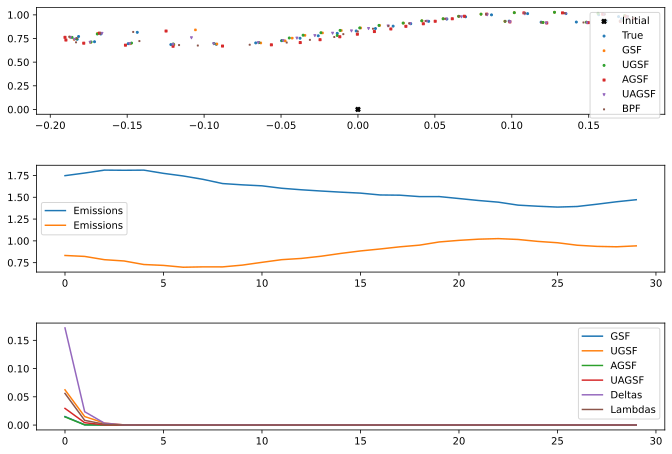

sim 15/100
key0:  [1491761296  588544249]
key:  [1968947799 1282838610]
       Time taken for GSF:  0.8167979717254639
       Time taken for UGSF:  0.9273941516876221
       Time taken for AGSF:  6.881825923919678
       Time taken for UAGSF:  6.703766107559204
       Time taken for BPF:  3.228904962539673
              GSF RMSE: 0.015694063
              UGSF RMSE: 0.025462821
              AGSF RMSE: 0.005371672
              UAGSF RMSE: 0.026641179
              BPF RMSE: 0.023828099


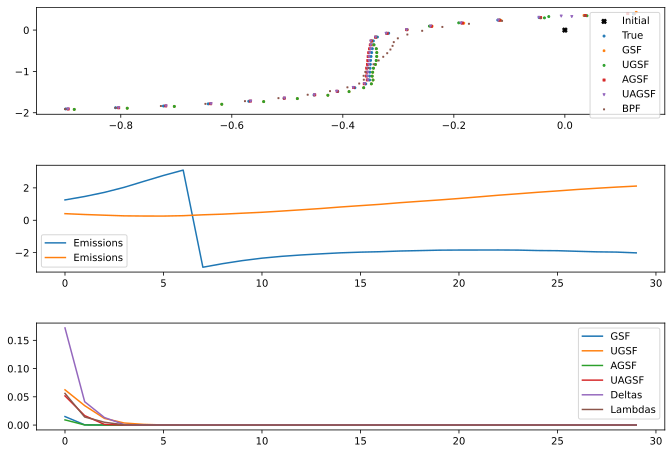

sim 16/100
key0:  [2142401925  580756533]
key:  [2808712755 3382142284]
       Time taken for GSF:  1.34934401512146
       Time taken for UGSF:  0.9106509685516357
       Time taken for AGSF:  6.4727301597595215
       Time taken for UAGSF:  7.186606168746948
       Time taken for BPF:  3.216181755065918
              GSF RMSE: 0.014748603
              UGSF RMSE: 0.03104902
              AGSF RMSE: 0.028563377
              UAGSF RMSE: 0.029288722
              BPF RMSE: 0.0054094126


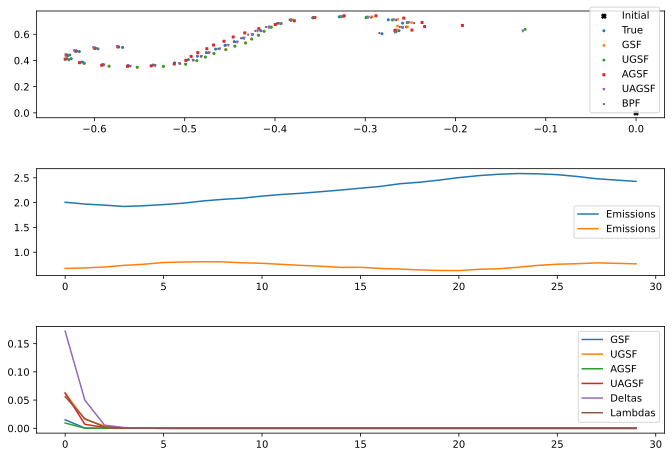

sim 17/100
key0:  [1214963262 2397950654]
key:  [2026553328  514088349]
       Time taken for GSF:  0.8047740459442139
       Time taken for UGSF:  0.9193029403686523
       Time taken for AGSF:  6.435525178909302
       Time taken for UAGSF:  7.258935928344727
       Time taken for BPF:  3.2634289264678955
              GSF RMSE: 0.008325254
              UGSF RMSE: 0.012413697
              AGSF RMSE: 0.008890912
              UAGSF RMSE: 0.010202951
              BPF RMSE: 0.00491303


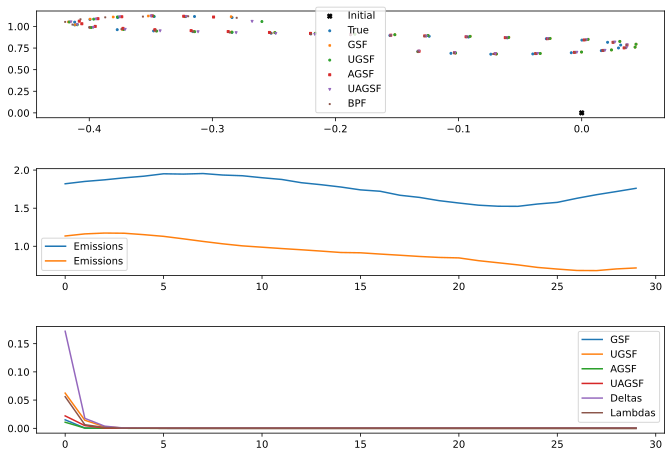

sim 18/100
key0:  [ 218736863 3855308191]
key:  [4161984306 3196801348]
       Time taken for GSF:  0.8316662311553955
       Time taken for UGSF:  0.9253489971160889
       Time taken for AGSF:  7.110182285308838
       Time taken for UAGSF:  6.848259925842285
       Time taken for BPF:  3.384413957595825
              GSF RMSE: 0.014781168
              UGSF RMSE: 0.023484178
              AGSF RMSE: 0.008613348
              UAGSF RMSE: 0.004747371
              BPF RMSE: 0.005567344


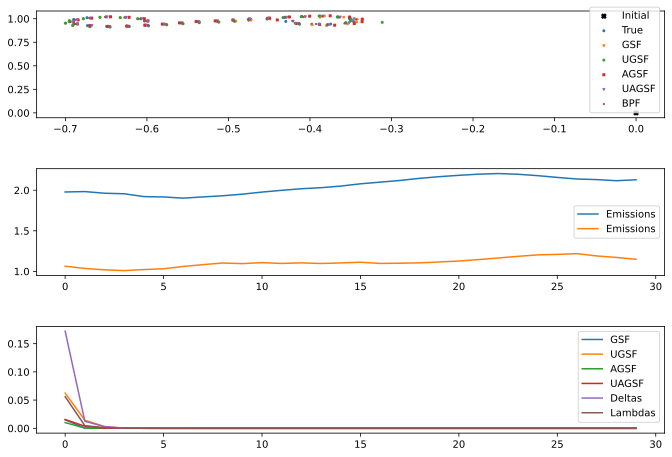

sim 19/100
key0:  [1151028487 2939992156]
key:  [1376876312 2772186225]
       Time taken for GSF:  0.8107068538665771
       Time taken for UGSF:  0.9116230010986328
       Time taken for AGSF:  7.1161768436431885
       Time taken for UAGSF:  6.631121873855591
       Time taken for BPF:  3.277116060256958
              GSF RMSE: 0.014400123
              UGSF RMSE: 0.030094502
              AGSF RMSE: 0.008438436
              UAGSF RMSE: 0.014741534
              BPF RMSE: 0.0052042836


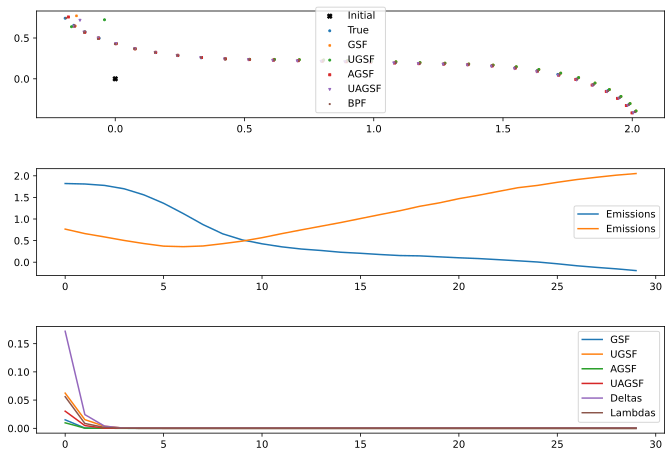

sim 20/100
key0:  [1209653932 4060347193]
key:  [2941757454  870593673]
       Time taken for GSF:  0.8244640827178955
       Time taken for UGSF:  0.9284420013427734
       Time taken for AGSF:  7.0845630168914795
       Time taken for UAGSF:  6.678186893463135
       Time taken for BPF:  3.304736375808716
              GSF RMSE: 0.017547531
              UGSF RMSE: 0.01927039
              AGSF RMSE: 0.011694315
              UAGSF RMSE: 0.0066798334
              BPF RMSE: 0.004699192


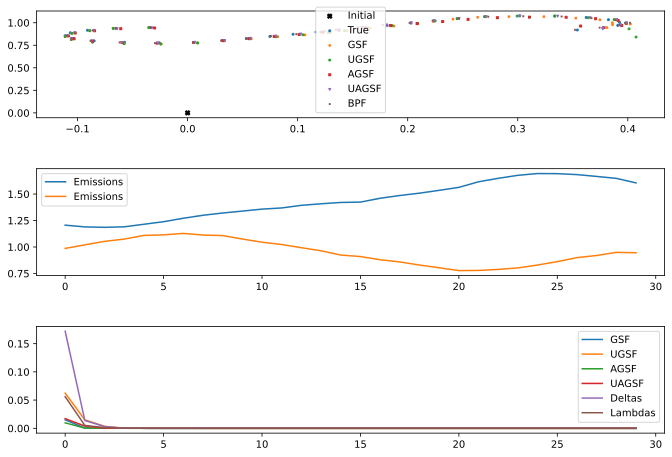

sim 21/100
key0:  [1294091905 2996091761]
key:  [2548412307  391727372]
       Time taken for GSF:  0.8260259628295898
       Time taken for UGSF:  0.9408679008483887
       Time taken for AGSF:  7.111166000366211
       Time taken for UAGSF:  6.680669069290161
       Time taken for BPF:  3.335923910140991
              GSF RMSE: 0.011203342
              UGSF RMSE: 0.02866119
              AGSF RMSE: 0.014102998
              UAGSF RMSE: 0.007593003
              BPF RMSE: 0.0033619069


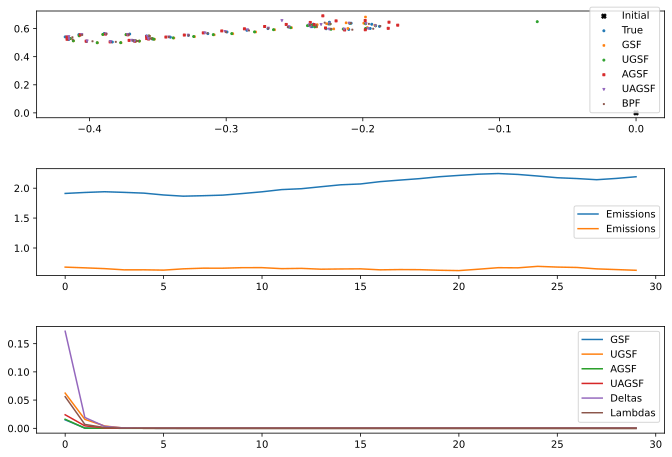

sim 22/100
key0:  [2157786727 3727309458]
key:  [3813321172 4101316537]
       Time taken for GSF:  0.8255782127380371
       Time taken for UGSF:  0.9242491722106934
       Time taken for AGSF:  7.205983877182007
       Time taken for UAGSF:  6.814484119415283
       Time taken for BPF:  3.297321081161499
              GSF RMSE: nan
              UGSF RMSE: 0.147329
              AGSF RMSE: 0.49870607
              UAGSF RMSE: 0.04776567
              BPF RMSE: 0.12474558


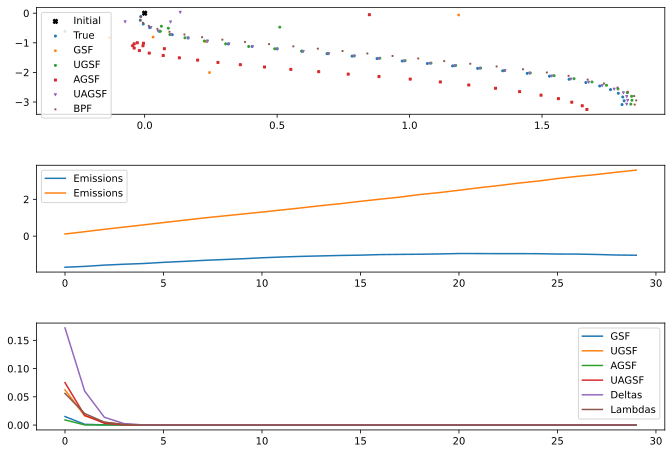

sim 23/100
key0:  [ 551681748 3783370645]
key:  [3170693929  505432508]
       Time taken for GSF:  0.8238358497619629
       Time taken for UGSF:  0.9280259609222412
       Time taken for AGSF:  6.489870071411133
       Time taken for UAGSF:  7.72189998626709
       Time taken for BPF:  3.3274118900299072
              GSF RMSE: 0.015610508
              UGSF RMSE: 0.030282266
              AGSF RMSE: 0.007412485
              UAGSF RMSE: 0.018752532
              BPF RMSE: 0.0063782274


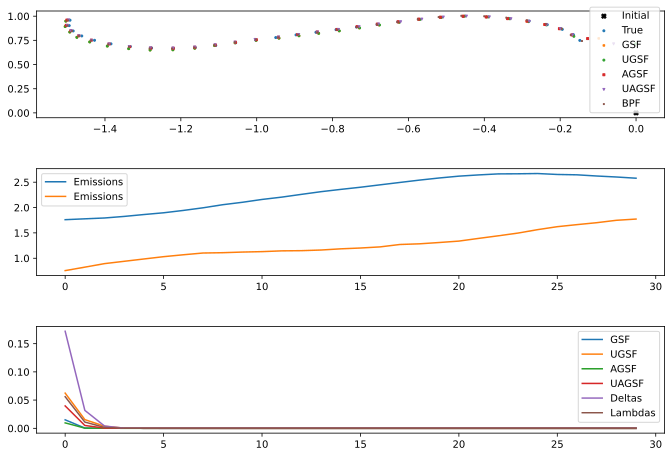

sim 24/100
key0:  [3225174916 3223194634]
key:  [1519423743 2956433696]
       Time taken for GSF:  0.8491640090942383
       Time taken for UGSF:  0.9240188598632812
       Time taken for AGSF:  6.423390865325928
       Time taken for UAGSF:  7.599247217178345
       Time taken for BPF:  3.2972071170806885
              GSF RMSE: 0.016220396
              UGSF RMSE: 0.023864372
              AGSF RMSE: 0.032696765
              UAGSF RMSE: 0.02218865
              BPF RMSE: 0.0046002


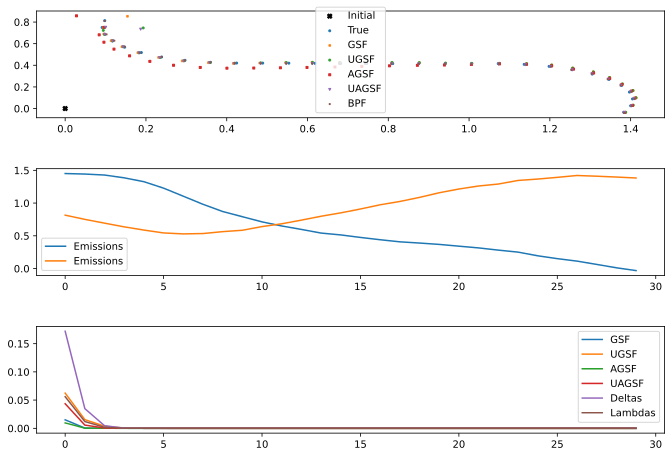

sim 25/100
key0:  [1210625804 1346048384]
key:  [ 593864388 3739305433]
       Time taken for GSF:  0.8275041580200195
       Time taken for UGSF:  0.9313218593597412
       Time taken for AGSF:  6.495348930358887
       Time taken for UAGSF:  6.657437086105347
       Time taken for BPF:  3.3627030849456787
              GSF RMSE: 0.013041077
              UGSF RMSE: 0.013686852
              AGSF RMSE: 0.008424919
              UAGSF RMSE: 0.008888658
              BPF RMSE: 0.021981003


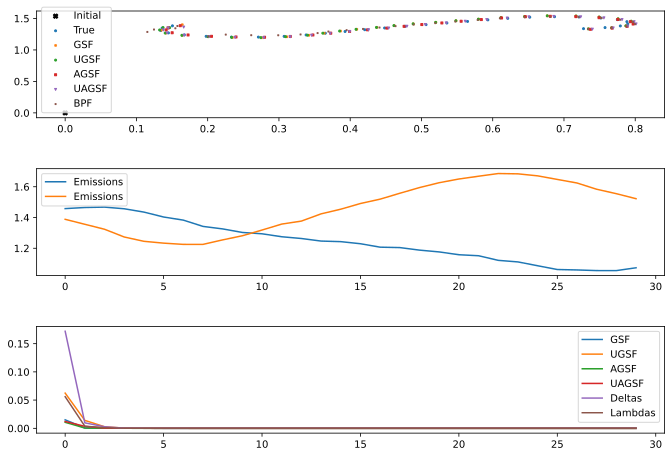

sim 26/100
key0:  [3352908700 3855442932]
key:  [2019875360  913777580]
       Time taken for GSF:  1.6932461261749268
       Time taken for UGSF:  0.9364938735961914
       Time taken for AGSF:  6.565124034881592
       Time taken for UAGSF:  6.789500951766968
       Time taken for BPF:  3.356823205947876
              GSF RMSE: 0.01363841
              UGSF RMSE: 0.026448613
              AGSF RMSE: 0.020356238
              UAGSF RMSE: 0.0077131325
              BPF RMSE: 0.0052512255


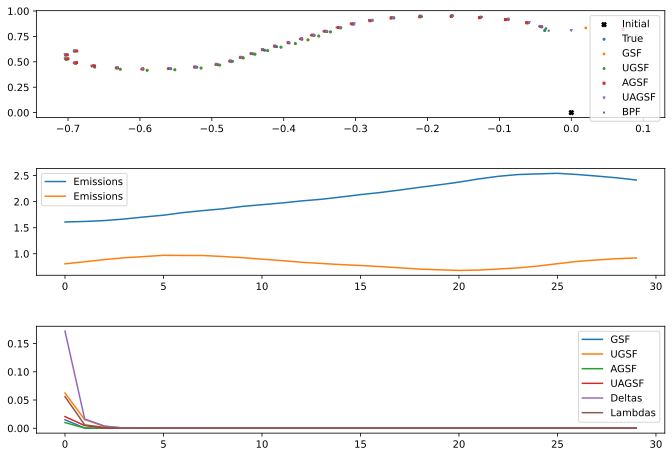

sim 27/100
key0:  [2424983569 3671623719]
key:  [ 886240072 1903776979]
       Time taken for GSF:  0.8294861316680908
       Time taken for UGSF:  0.9379947185516357
       Time taken for AGSF:  7.483031988143921
       Time taken for UAGSF:  6.947448253631592
       Time taken for BPF:  3.5082807540893555
              GSF RMSE: 0.012732097
              UGSF RMSE: 0.024999432
              AGSF RMSE: 0.009488849
              UAGSF RMSE: 0.017299987
              BPF RMSE: 0.005513482


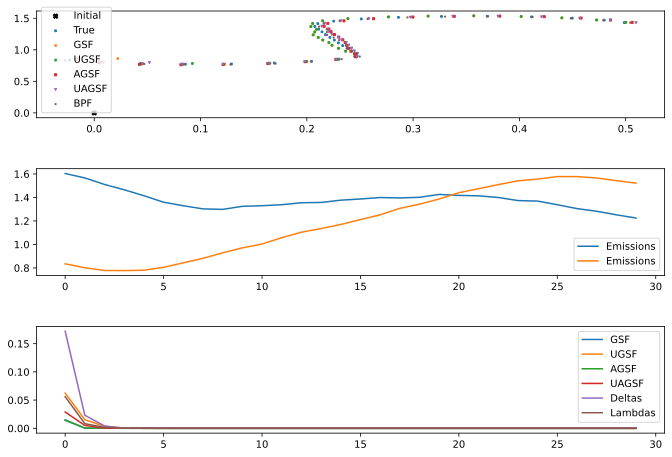

sim 28/100
key0:  [3682768791 4179160189]
key:  [3658883292 3188421254]
       Time taken for GSF:  0.8799211978912354
       Time taken for UGSF:  0.9774062633514404
       Time taken for AGSF:  6.612004995346069
       Time taken for UAGSF:  8.160657167434692
       Time taken for BPF:  3.4655659198760986
              GSF RMSE: 0.01642362
              UGSF RMSE: 0.0803636
              AGSF RMSE: 0.026532773
              UAGSF RMSE: 0.02863389
              BPF RMSE: 0.019613214


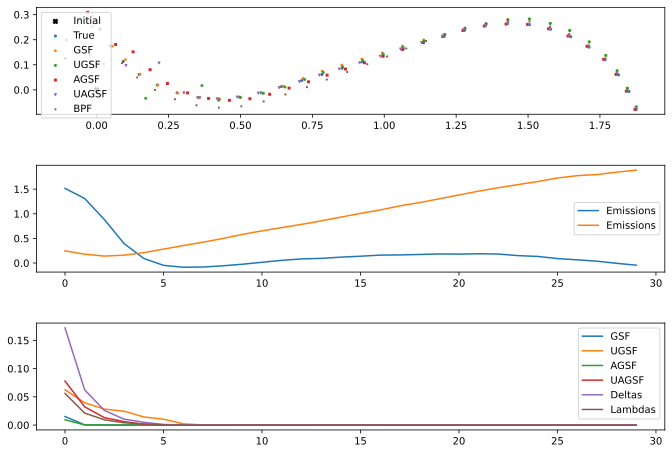

sim 29/100
key0:  [4241594673 2549027846]
key:  [2880162605 1913929932]
       Time taken for GSF:  0.8683500289916992
       Time taken for UGSF:  0.9639182090759277
       Time taken for AGSF:  7.003557920455933
       Time taken for UAGSF:  6.816583871841431
       Time taken for BPF:  3.3569018840789795
              GSF RMSE: 0.013572594
              UGSF RMSE: 0.027641552
              AGSF RMSE: 0.011078434
              UAGSF RMSE: 0.011478978
              BPF RMSE: 0.0034376904


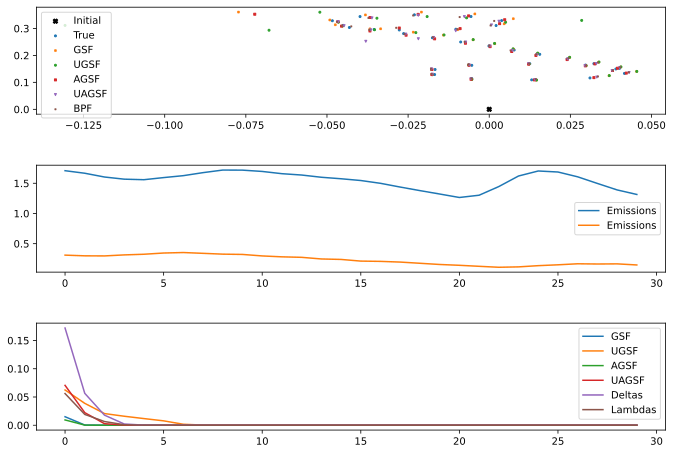

sim 30/100
key0:  [4127811398 1827045953]
key:  [2836373118 2003878861]
       Time taken for GSF:  0.8681521415710449
       Time taken for UGSF:  0.9513840675354004
       Time taken for AGSF:  6.535665273666382
       Time taken for UAGSF:  6.941691875457764
       Time taken for BPF:  3.3639891147613525
              GSF RMSE: 0.098086536
              UGSF RMSE: 0.06842734
              AGSF RMSE: 2.0304055
              UAGSF RMSE: 0.042127065
              BPF RMSE: 0.004441691


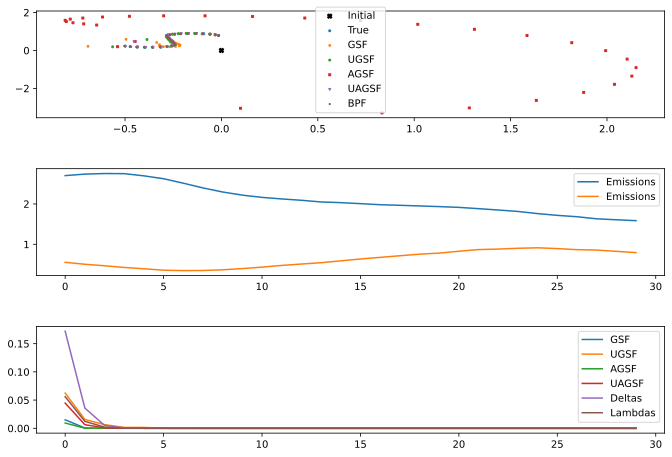

sim 31/100
key0:  [2667547357 3083571703]
key:  [1714563807 3897966836]
       Time taken for GSF:  0.8353080749511719
       Time taken for UGSF:  0.9462451934814453
       Time taken for AGSF:  7.97688102722168
       Time taken for UAGSF:  7.0577919483184814
       Time taken for BPF:  3.446483850479126
              GSF RMSE: 0.013515477
              UGSF RMSE: 0.022214884
              AGSF RMSE: 0.014271946
              UAGSF RMSE: 0.02055037
              BPF RMSE: 0.012031303


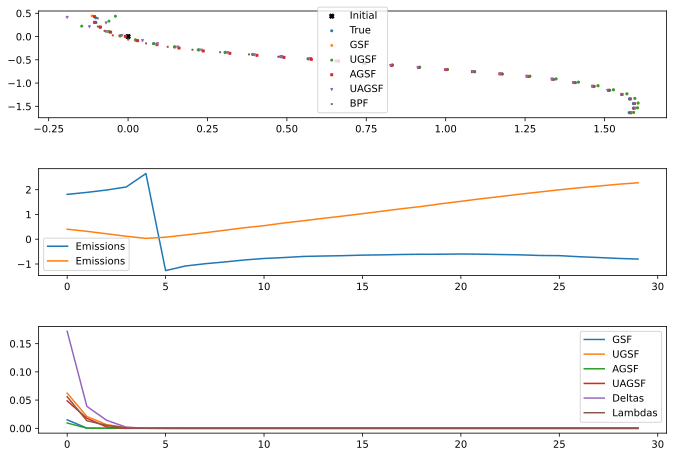

sim 32/100
key0:  [4097068318 3279476549]
key:  [ 66919507 666722832]
       Time taken for GSF:  0.8836119174957275
       Time taken for UGSF:  0.9822170734405518
       Time taken for AGSF:  6.560436010360718
       Time taken for UAGSF:  6.850877285003662
       Time taken for BPF:  4.7119691371917725
              GSF RMSE: 0.028009748
              UGSF RMSE: 0.06104158
              AGSF RMSE: 0.012971462
              UAGSF RMSE: 0.026159933
              BPF RMSE: 0.1775932


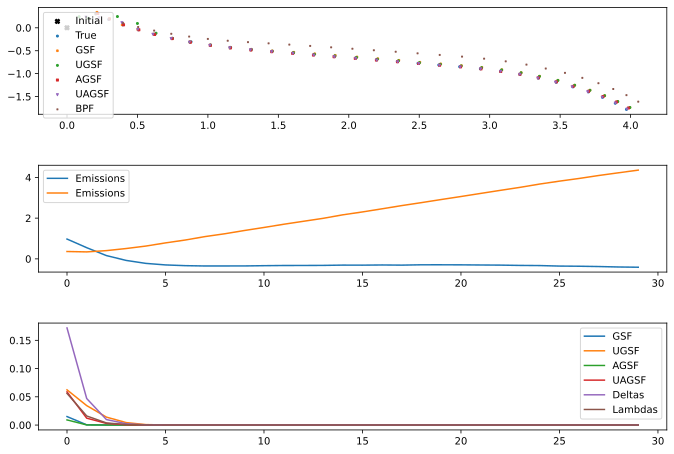

sim 33/100
key0:  [1352548185 3377347842]
key:  [1142431104 4196393820]
       Time taken for GSF:  0.8929493427276611
       Time taken for UGSF:  0.9681921005249023
       Time taken for AGSF:  6.977631092071533
       Time taken for UAGSF:  7.1375792026519775
       Time taken for BPF:  3.4227168560028076
              GSF RMSE: 0.016461853
              UGSF RMSE: 0.0248779
              AGSF RMSE: 0.020758346
              UAGSF RMSE: 0.025312435
              BPF RMSE: 0.011653132


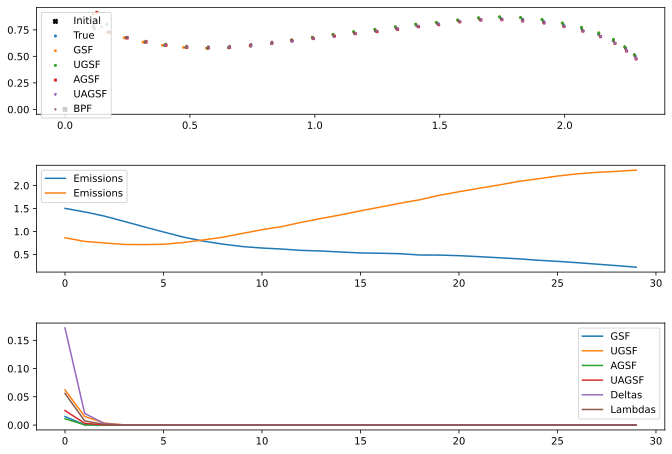

sim 34/100
key0:  [1426702441 1492789755]
key:  [ 550753349 3769041584]
       Time taken for GSF:  1.3605937957763672
       Time taken for UGSF:  1.1279258728027344
       Time taken for AGSF:  8.472354888916016
       Time taken for UAGSF:  7.0716259479522705
       Time taken for BPF:  3.4594340324401855
              GSF RMSE: nan
              UGSF RMSE: 0.022083763
              AGSF RMSE: 0.006139662
              UAGSF RMSE: 0.006275858
              BPF RMSE: 0.0044047637


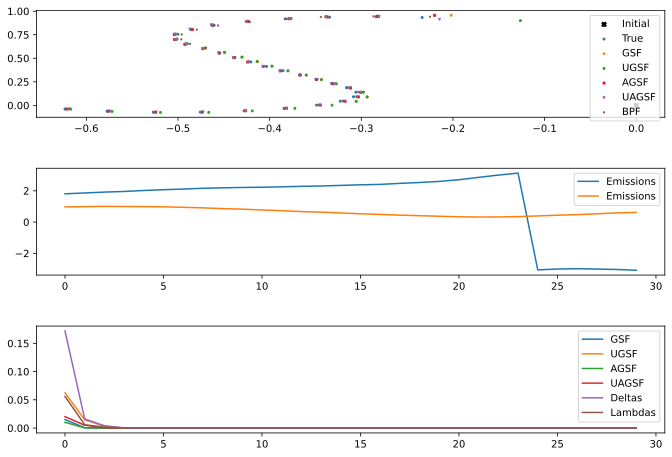

sim 35/100
key0:  [3879714039  537011209]
key:  [701925360 963976890]
       Time taken for GSF:  0.8746278285980225
       Time taken for UGSF:  0.9580068588256836
       Time taken for AGSF:  6.543171167373657
       Time taken for UAGSF:  7.027321815490723
       Time taken for BPF:  3.445786714553833
              GSF RMSE: 0.011628535
              UGSF RMSE: 0.024303908
              AGSF RMSE: 0.009150851
              UAGSF RMSE: 0.011856147
              BPF RMSE: 0.0057999683


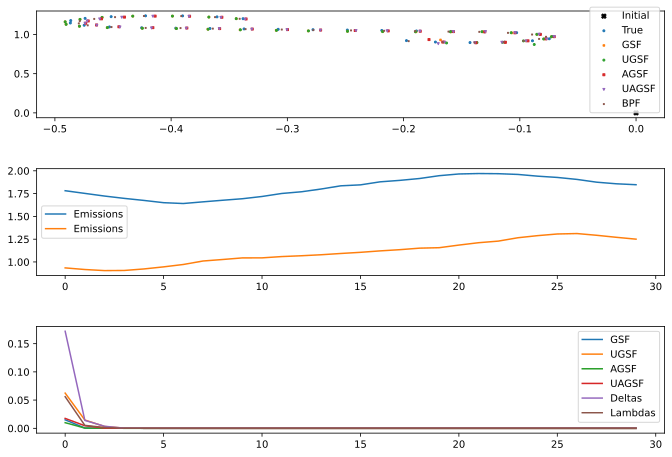

sim 36/100
key0:  [3583935617  858713800]
key:  [3843978566 1916095287]
       Time taken for GSF:  0.8752498626708984
       Time taken for UGSF:  0.9563882350921631
       Time taken for AGSF:  8.066661834716797
       Time taken for UAGSF:  7.016438007354736
       Time taken for BPF:  3.4843220710754395
              GSF RMSE: 0.011861087
              UGSF RMSE: 0.030234547
              AGSF RMSE: 0.0048471154
              UAGSF RMSE: 0.019007133
              BPF RMSE: 0.0039105806


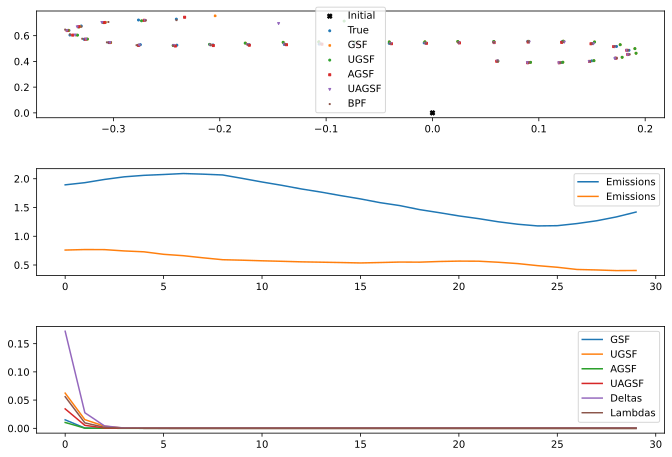

sim 37/100
key0:  [1381516244 1378949135]
key:  [4090523957 2903795642]
       Time taken for GSF:  0.8777637481689453
       Time taken for UGSF:  0.9544141292572021
       Time taken for AGSF:  6.5450170040130615
       Time taken for UAGSF:  8.549740076065063
       Time taken for BPF:  3.4366438388824463
              GSF RMSE: 0.006622615
              UGSF RMSE: 0.010919299
              AGSF RMSE: 0.007484226
              UAGSF RMSE: 0.0064160316
              BPF RMSE: 0.0061561037


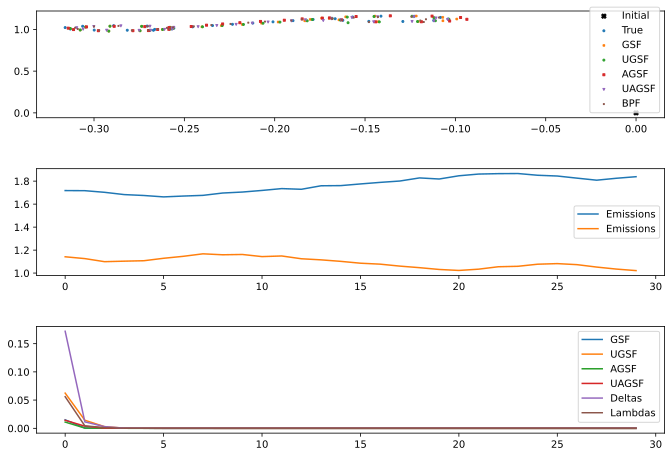

sim 38/100
key0:  [    795349 3626361155]
key:  [2060698472 1935421892]
       Time taken for GSF:  0.8800008296966553
       Time taken for UGSF:  0.9902441501617432
       Time taken for AGSF:  7.09837007522583
       Time taken for UAGSF:  7.436792612075806
       Time taken for BPF:  3.6108169555664062
              GSF RMSE: 0.014458141
              UGSF RMSE: 0.016954744
              AGSF RMSE: 0.023266312
              UAGSF RMSE: 0.0234965
              BPF RMSE: 0.004362803


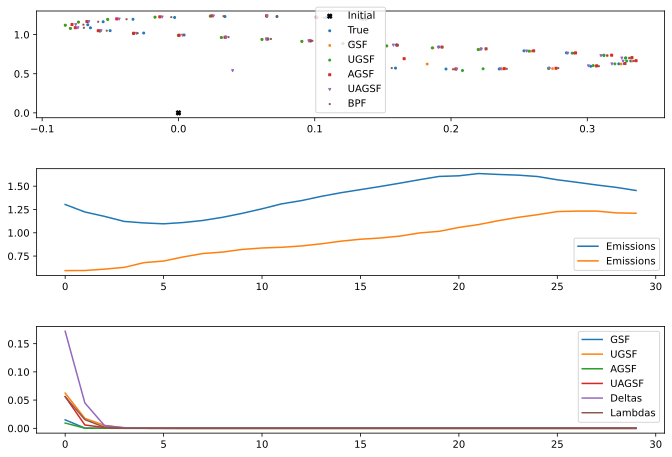

sim 39/100
key0:  [1443475802 1513503680]
key:  [3461804228 1821501735]
       Time taken for GSF:  0.9307048320770264
       Time taken for UGSF:  1.008727788925171
       Time taken for AGSF:  6.694994211196899
       Time taken for UAGSF:  8.490490913391113
       Time taken for BPF:  3.391187906265259
              GSF RMSE: 0.023857256
              UGSF RMSE: 0.020761997
              AGSF RMSE: 0.021603193
              UAGSF RMSE: 0.00928591
              BPF RMSE: 0.0112901


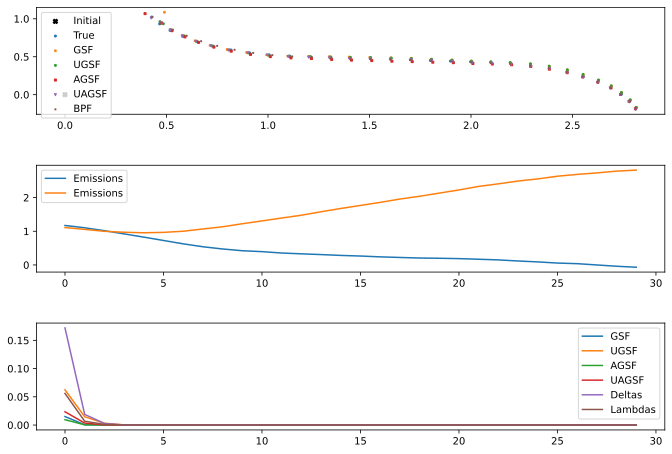

sim 40/100
key0:  [3293209344  859638991]
key:  [2095245717  513504677]
       Time taken for GSF:  0.8627262115478516
       Time taken for UGSF:  0.9684929847717285
       Time taken for AGSF:  6.630451917648315
       Time taken for UAGSF:  6.81818699836731
       Time taken for BPF:  3.3507580757141113
              GSF RMSE: 0.011498171
              UGSF RMSE: 0.025346307
              AGSF RMSE: 0.007439945
              UAGSF RMSE: 0.016699906
              BPF RMSE: 0.014000666


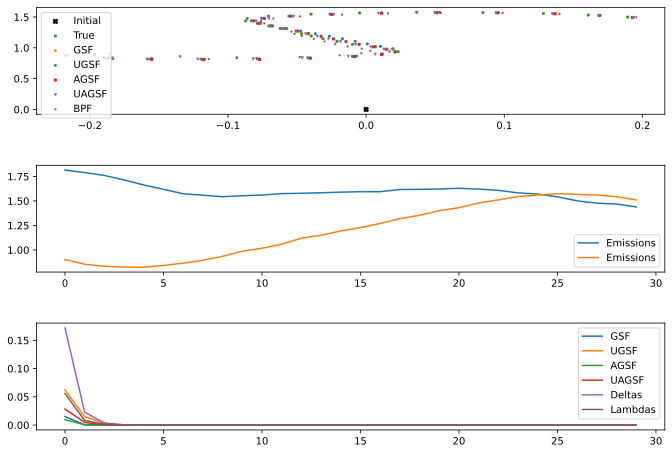

sim 41/100
key0:  [ 135286280 1686744072]
key:  [ 809419074 2446151527]
       Time taken for GSF:  0.8596768379211426
       Time taken for UGSF:  0.9593737125396729
       Time taken for AGSF:  6.50735878944397
       Time taken for UAGSF:  8.76893424987793
       Time taken for BPF:  3.371907949447632
              GSF RMSE: 0.03016599
              UGSF RMSE: 0.06868601
              AGSF RMSE: 1.0433494
              UAGSF RMSE: 0.031896476
              BPF RMSE: 0.023203572


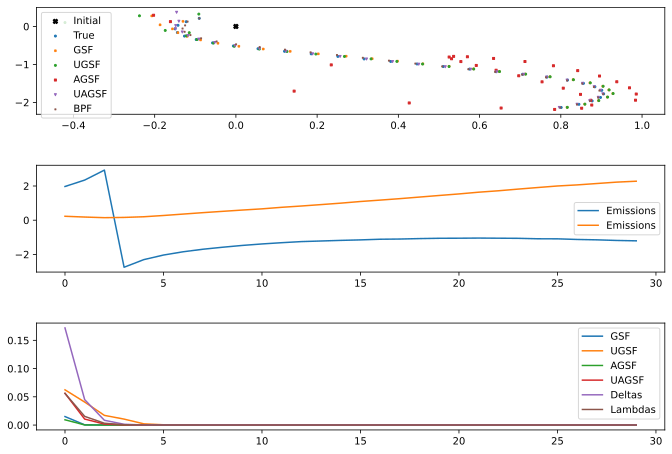

sim 42/100
key0:  [2946973044  706253099]
key:  [2903432635 1884464422]
       Time taken for GSF:  0.8795630931854248
       Time taken for UGSF:  0.9660882949829102
       Time taken for AGSF:  6.798328638076782
       Time taken for UAGSF:  7.286854028701782
       Time taken for BPF:  3.4223921298980713
              GSF RMSE: 0.019027019
              UGSF RMSE: 0.029962251
              AGSF RMSE: 0.014149904
              UAGSF RMSE: 0.01650684
              BPF RMSE: 0.013335229


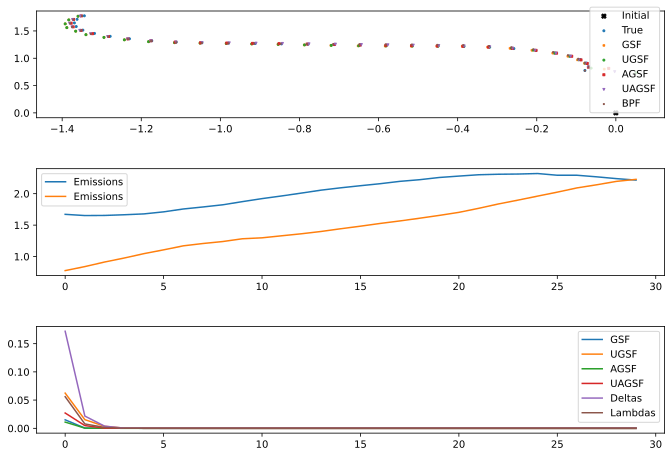

sim 43/100
key0:  [2964417844    5936222]
key:  [1446088450 2397721984]
       Time taken for GSF:  1.4290459156036377
       Time taken for UGSF:  0.9955661296844482
       Time taken for AGSF:  6.690093994140625
       Time taken for UAGSF:  8.835803031921387
       Time taken for BPF:  3.384795904159546
              GSF RMSE: 0.012671082
              UGSF RMSE: 0.0106866835
              AGSF RMSE: 0.0071991673
              UAGSF RMSE: 0.0073585156
              BPF RMSE: 0.012723148


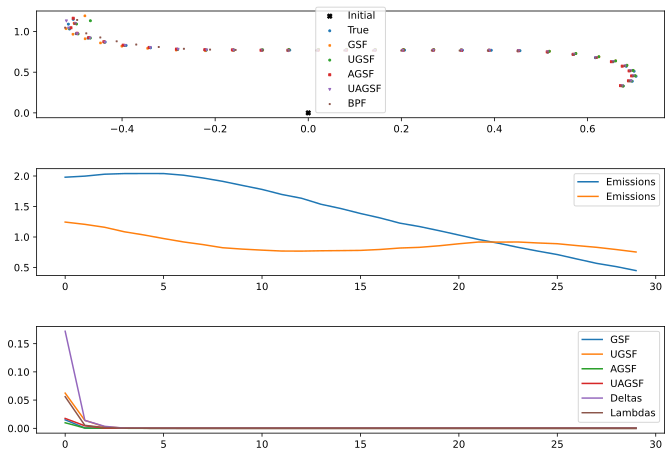

sim 44/100
key0:  [1289099435 4263145636]
key:  [4215328939  815994393]
       Time taken for GSF:  0.8936700820922852
       Time taken for UGSF:  1.0065670013427734
       Time taken for AGSF:  6.597136974334717
       Time taken for UAGSF:  7.068925857543945
       Time taken for BPF:  3.334398031234741
              GSF RMSE: 0.020801298
              UGSF RMSE: 0.023227802
              AGSF RMSE: 0.011202663
              UAGSF RMSE: 0.0069602253
              BPF RMSE: 0.37839717


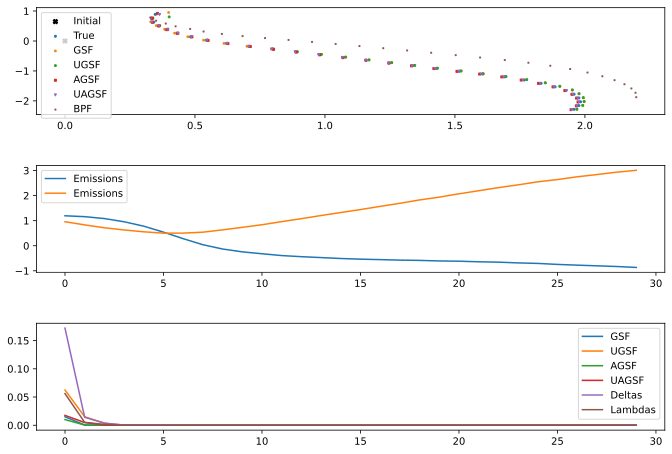

sim 45/100
key0:  [3488432680 1478598887]
key:  [1483610594  482253136]
       Time taken for GSF:  0.878974199295044
       Time taken for UGSF:  1.1110610961914062
       Time taken for AGSF:  6.664060831069946
       Time taken for UAGSF:  9.02665901184082
       Time taken for BPF:  3.39355731010437
              GSF RMSE: 0.01563414
              UGSF RMSE: 0.0155087905
              AGSF RMSE: 0.0153699545
              UAGSF RMSE: 0.0078128725
              BPF RMSE: 0.013860012


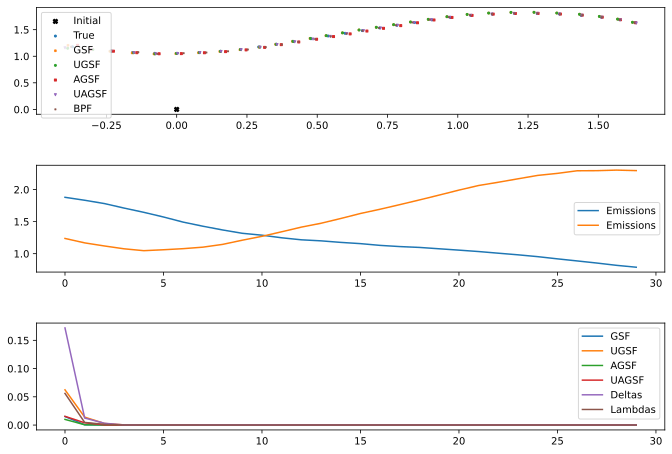

sim 46/100
key0:  [3257233935 1952231522]
key:  [ 929230699 3344410934]
       Time taken for GSF:  0.8886759281158447
       Time taken for UGSF:  0.9685611724853516
       Time taken for AGSF:  7.310667037963867
       Time taken for UAGSF:  6.701023101806641
       Time taken for BPF:  3.3762941360473633
              GSF RMSE: 0.013875226
              UGSF RMSE: 0.028100068
              AGSF RMSE: 0.007592158
              UAGSF RMSE: 0.028160159
              BPF RMSE: 0.004982998


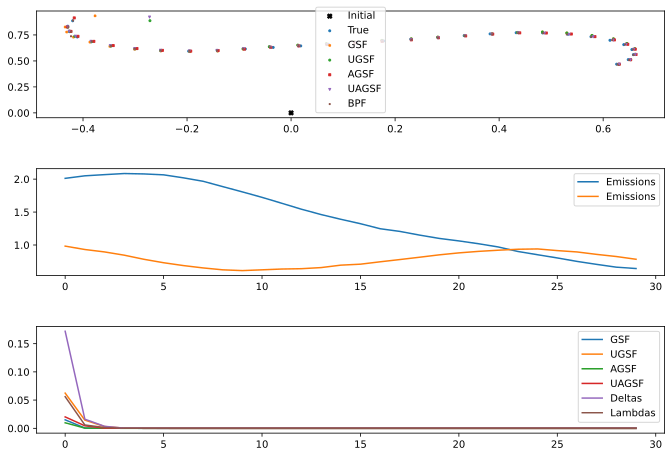

sim 47/100
key0:  [445797803 521715105]
key:  [1593000320  811188585]
       Time taken for GSF:  0.8572840690612793
       Time taken for UGSF:  0.9471549987792969
       Time taken for AGSF:  6.5176661014556885
       Time taken for UAGSF:  9.002383947372437
       Time taken for BPF:  3.4617738723754883
              GSF RMSE: 0.017726107
              UGSF RMSE: 0.021025892
              AGSF RMSE: 0.011245047
              UAGSF RMSE: 0.018820629
              BPF RMSE: 0.007168656


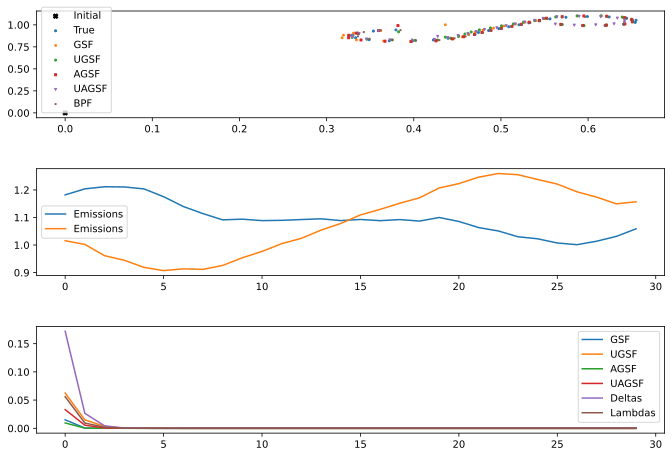

sim 48/100
key0:  [ 851777578 3595087810]
key:  [3647434706 1867762507]
       Time taken for GSF:  0.8559510707855225
       Time taken for UGSF:  0.95654296875
       Time taken for AGSF:  6.688222885131836
       Time taken for UAGSF:  6.845162868499756
       Time taken for BPF:  3.343384027481079
              GSF RMSE: 0.0127652455
              UGSF RMSE: 0.028616674
              AGSF RMSE: 0.71992207
              UAGSF RMSE: 0.016373703
              BPF RMSE: 0.256477


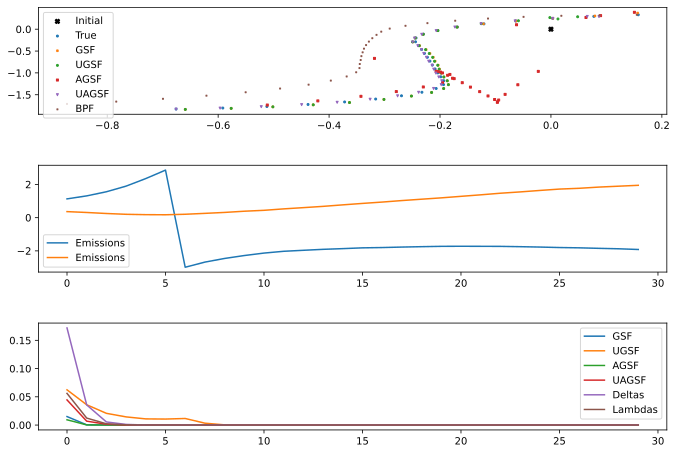

sim 49/100
key0:  [ 183218508 3553746893]
key:  [1232465061  595698750]
       Time taken for GSF:  0.8623738288879395
       Time taken for UGSF:  0.9471039772033691
       Time taken for AGSF:  6.533016920089722
       Time taken for UAGSF:  6.766932010650635
       Time taken for BPF:  3.375808000564575
              GSF RMSE: 0.011939275
              UGSF RMSE: 0.023479696
              AGSF RMSE: 0.014264556
              UAGSF RMSE: 0.030542908
              BPF RMSE: 0.010703391


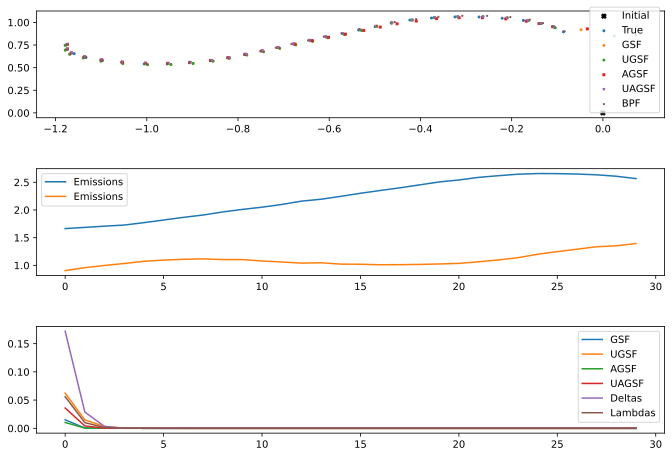

sim 50/100
key0:  [3343796599 1184364315]
key:  [1252721719  809124761]
       Time taken for GSF:  2.9159040451049805
       Time taken for UGSF:  0.9947118759155273
       Time taken for AGSF:  6.902680158615112
       Time taken for UAGSF:  6.9819440841674805
       Time taken for BPF:  3.331902027130127
              GSF RMSE: 0.013929275
              UGSF RMSE: 0.021473175
              AGSF RMSE: 0.008271084
              UAGSF RMSE: 0.0135304015
              BPF RMSE: 0.0059378296


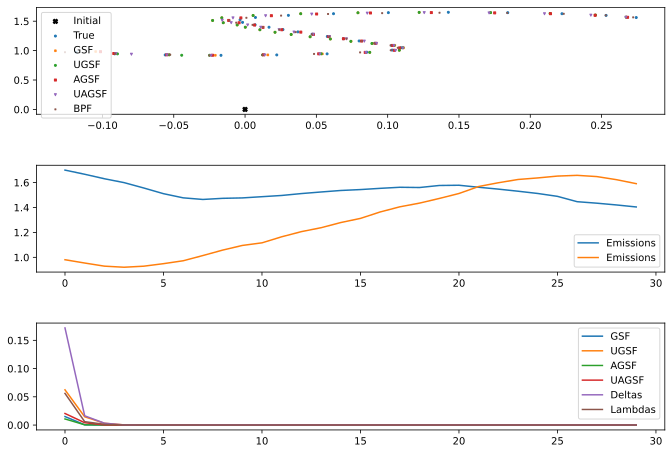

sim 51/100
key0:  [3381932131 2472650865]
key:  [2175510096 1484791526]
       Time taken for GSF:  0.9188930988311768
       Time taken for UGSF:  1.0911688804626465
       Time taken for AGSF:  7.009248971939087
       Time taken for UAGSF:  7.227280139923096
       Time taken for BPF:  3.433521032333374
              GSF RMSE: 0.014099403
              UGSF RMSE: 0.02389871
              AGSF RMSE: 0.0095565235
              UAGSF RMSE: 0.010061891
              BPF RMSE: 0.008153427


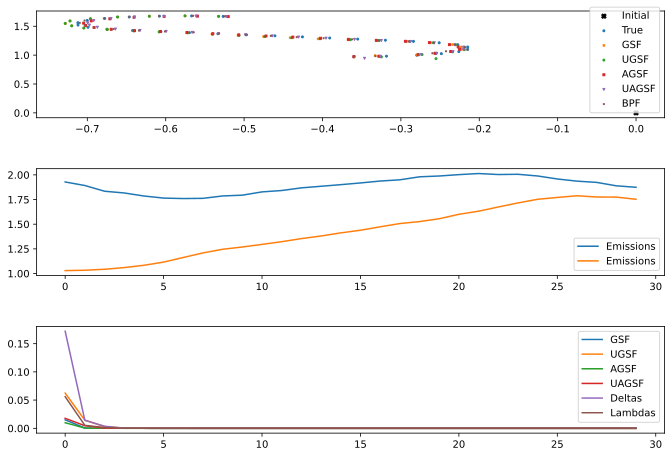

sim 52/100
key0:  [ 130718858 2352678943]
key:  [1299744928 2761854373]
       Time taken for GSF:  0.9138298034667969
       Time taken for UGSF:  0.9615697860717773
       Time taken for AGSF:  8.690478086471558
       Time taken for UAGSF:  7.203532934188843
       Time taken for BPF:  3.4326400756835938
              GSF RMSE: 0.01138451
              UGSF RMSE: 0.013953278
              AGSF RMSE: 0.012702883
              UAGSF RMSE: 0.010278032
              BPF RMSE: 0.014192467


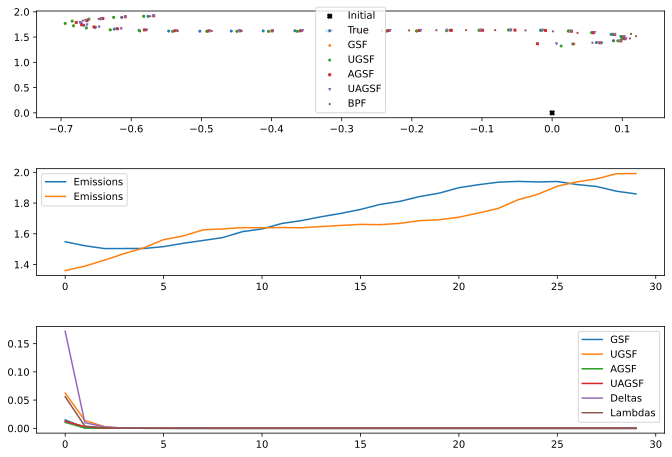

sim 53/100
key0:  [1093701459  347181194]
key:  [3860313114 1934098228]
       Time taken for GSF:  0.9221570491790771
       Time taken for UGSF:  1.6522870063781738
       Time taken for AGSF:  6.720782041549683
       Time taken for UAGSF:  7.213780879974365
       Time taken for BPF:  3.3541650772094727
              GSF RMSE: 0.016021859
              UGSF RMSE: 0.033503924
              AGSF RMSE: 0.017397813
              UAGSF RMSE: 0.019298727
              BPF RMSE: 0.004586036


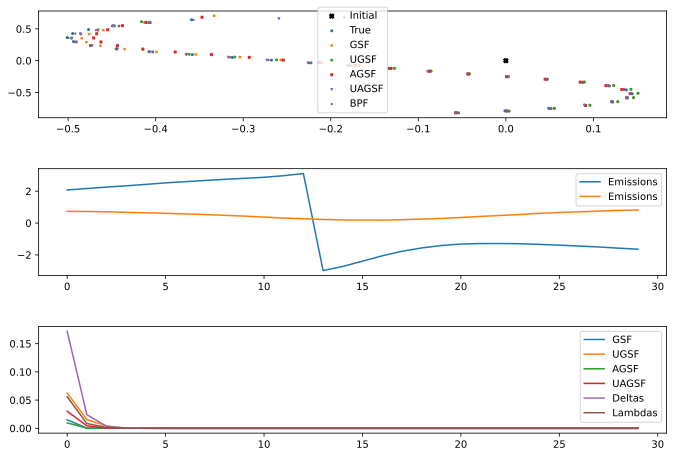

sim 54/100
key0:  [2878158215 3784790468]
key:  [2611459947  489075845]
       Time taken for GSF:  0.9056181907653809
       Time taken for UGSF:  0.9475150108337402
       Time taken for AGSF:  6.656402111053467
       Time taken for UAGSF:  7.069149971008301
       Time taken for BPF:  3.4369428157806396
              GSF RMSE: 0.02124079
              UGSF RMSE: 0.02324534
              AGSF RMSE: 0.01066262
              UAGSF RMSE: 0.007733583
              BPF RMSE: 0.0065514


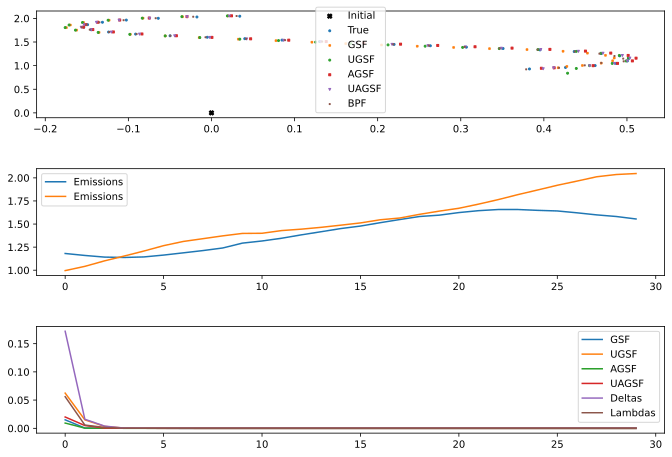

sim 55/100
key0:  [1423747144 3160601483]
key:  [1088751577  319449869]
       Time taken for GSF:  0.9240097999572754
       Time taken for UGSF:  1.0329859256744385
       Time taken for AGSF:  6.584537029266357
       Time taken for UAGSF:  6.9728710651397705
       Time taken for BPF:  3.4723081588745117
              GSF RMSE: 0.01729863
              UGSF RMSE: 0.017356537
              AGSF RMSE: 0.005780977
              UAGSF RMSE: 0.0107471235
              BPF RMSE: 0.0071808575


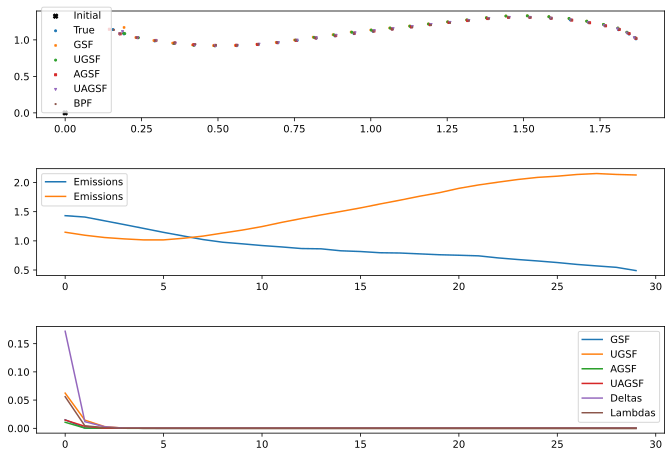

sim 56/100
key0:  [ 176956694 3442584173]
key:  [1816131912 2839293455]
       Time taken for GSF:  0.9883689880371094
       Time taken for UGSF:  0.9953198432922363
       Time taken for AGSF:  6.601562023162842
       Time taken for UAGSF:  7.242691993713379
       Time taken for BPF:  3.3761041164398193
              GSF RMSE: 0.01251674
              UGSF RMSE: 0.01789962
              AGSF RMSE: 0.010671941
              UAGSF RMSE: 0.01863674
              BPF RMSE: 0.007020619


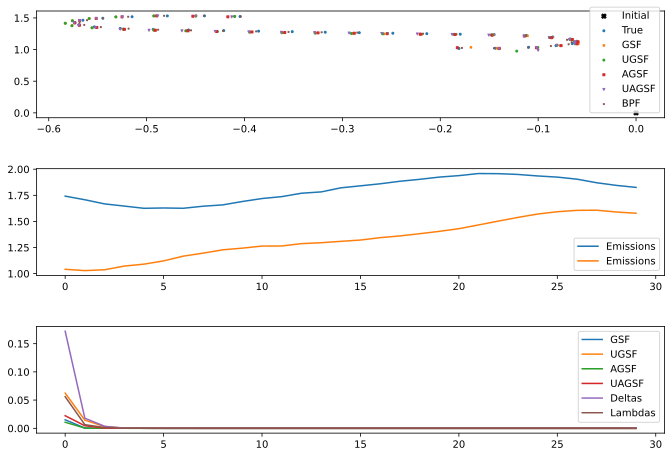

sim 57/100
key0:  [3392008150 1726277541]
key:  [1611190576 1974266124]
       Time taken for GSF:  0.8897089958190918
       Time taken for UGSF:  0.9863088130950928
       Time taken for AGSF:  6.610107183456421
       Time taken for UAGSF:  9.74882197380066
       Time taken for BPF:  3.4009132385253906
              GSF RMSE: 0.011976359
              UGSF RMSE: 0.026633658
              AGSF RMSE: 0.0048587495
              UAGSF RMSE: 0.008818411
              BPF RMSE: 0.0061350525


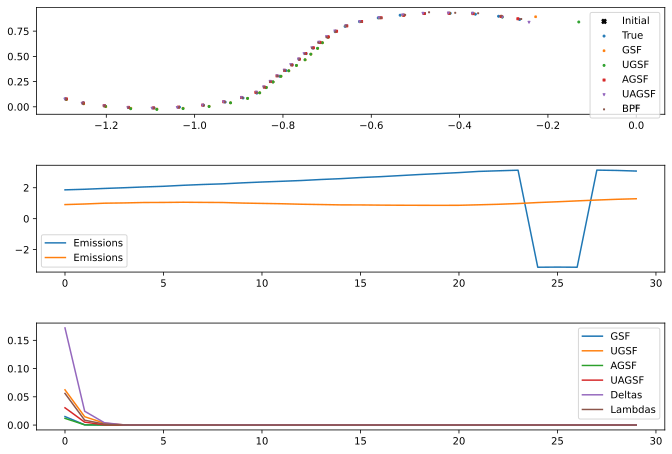

sim 58/100
key0:  [2476375293 3756013201]
key:  [3539195822  322384264]
       Time taken for GSF:  0.8887019157409668
       Time taken for UGSF:  0.9601578712463379
       Time taken for AGSF:  6.708588123321533
       Time taken for UAGSF:  7.019094944000244
       Time taken for BPF:  3.5825181007385254
              GSF RMSE: 0.011352951
              UGSF RMSE: 0.02307541
              AGSF RMSE: 0.01270881
              UAGSF RMSE: 0.019967005
              BPF RMSE: 0.0044512264


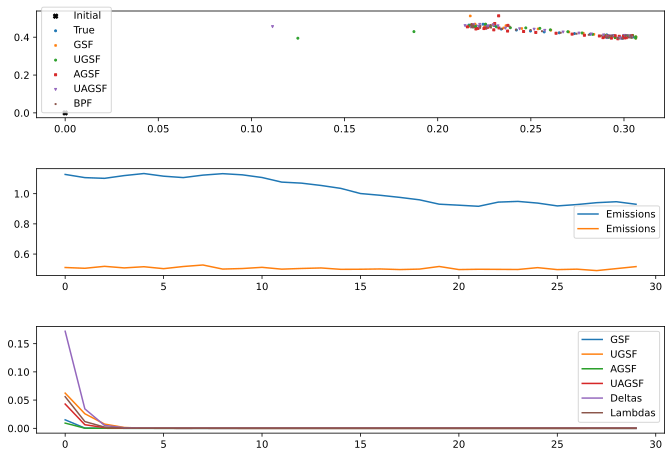

sim 59/100
key0:  [2481040864 2609313738]
key:  [2984320191 3303220167]
       Time taken for GSF:  0.8824489116668701
       Time taken for UGSF:  0.9832792282104492
       Time taken for AGSF:  6.587383985519409
       Time taken for UAGSF:  7.123955011367798
       Time taken for BPF:  3.4789040088653564
              GSF RMSE: nan
              UGSF RMSE: 0.09038193
              AGSF RMSE: 1.3659426
              UAGSF RMSE: 2.8879716
              BPF RMSE: 0.007725278


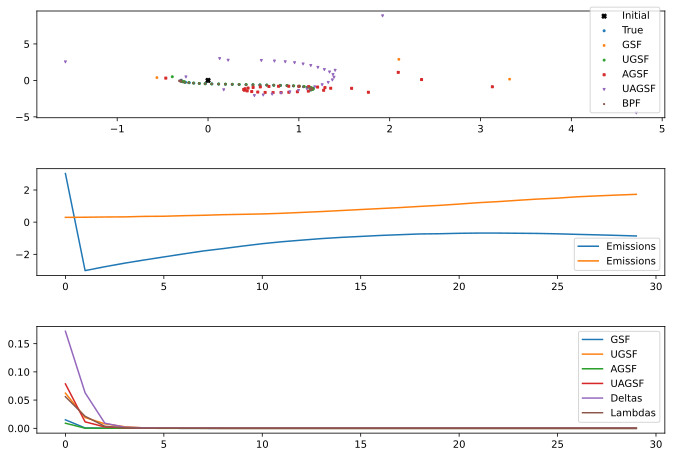

sim 60/100
key0:  [ 975156671 1624514521]
key:  [ 780669193 4231224228]
       Time taken for GSF:  0.8845779895782471
       Time taken for UGSF:  1.0673699378967285
       Time taken for AGSF:  9.316596984863281
       Time taken for UAGSF:  7.102963924407959
       Time taken for BPF:  3.404329776763916
              GSF RMSE: 0.012918596
              UGSF RMSE: 0.015754081
              AGSF RMSE: 0.043775022
              UAGSF RMSE: 0.019060144
              BPF RMSE: 0.0047316207


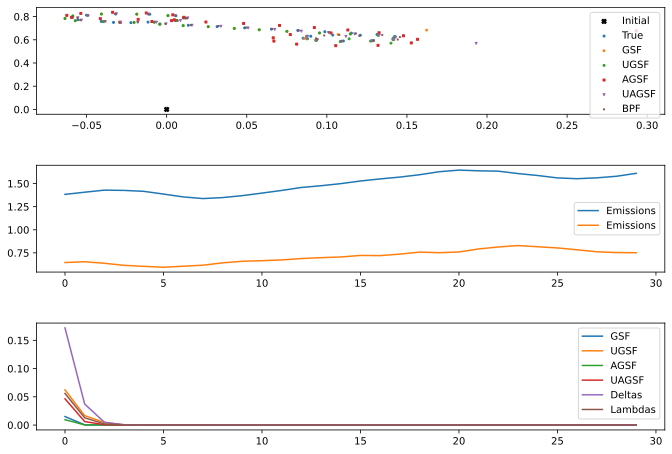

sim 61/100
key0:  [1064902070 2730719367]
key:  [  15283692 3968166679]
       Time taken for GSF:  0.920712947845459
       Time taken for UGSF:  1.004235029220581
       Time taken for AGSF:  6.60512113571167
       Time taken for UAGSF:  6.988622188568115
       Time taken for BPF:  3.414547920227051
              GSF RMSE: 0.009326473
              UGSF RMSE: 0.023246516
              AGSF RMSE: 0.0046412842
              UAGSF RMSE: 0.025568064
              BPF RMSE: 0.003152536


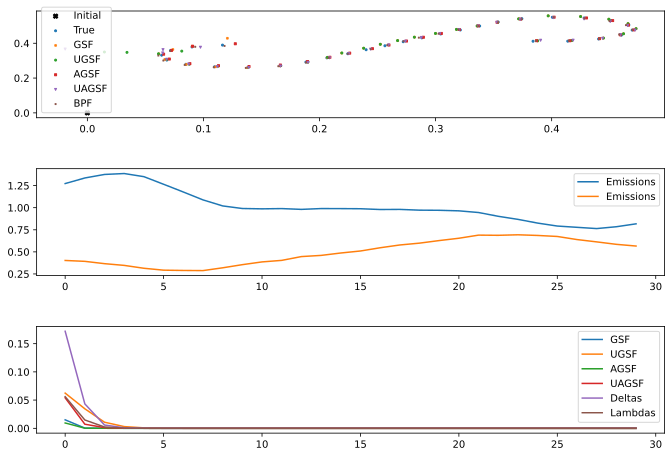

sim 62/100
key0:  [ 889232618 3175102760]
key:  [4044479483 2856481839]
       Time taken for GSF:  0.9282169342041016
       Time taken for UGSF:  1.007699966430664
       Time taken for AGSF:  6.654484033584595
       Time taken for UAGSF:  7.018487215042114
       Time taken for BPF:  3.4486539363861084
              GSF RMSE: 0.012105922
              UGSF RMSE: 0.013411335
              AGSF RMSE: 0.0066038226
              UAGSF RMSE: 0.0073511563
              BPF RMSE: 0.008026397


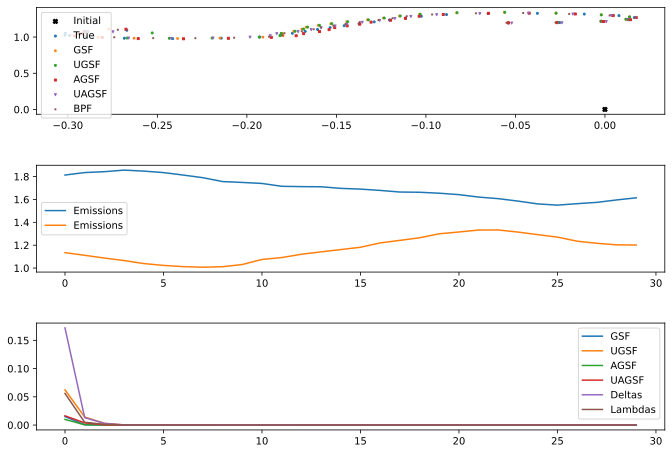

sim 63/100
key0:  [904012501 348926164]
key:  [834529741 350132673]
       Time taken for GSF:  1.3527960777282715
       Time taken for UGSF:  3.731667995452881
       Time taken for AGSF:  6.816749811172485
       Time taken for UAGSF:  7.1093058586120605
       Time taken for BPF:  3.4332518577575684
              GSF RMSE: 0.04896726
              UGSF RMSE: 0.07615456
              AGSF RMSE: 0.45962843
              UAGSF RMSE: 0.034325503
              BPF RMSE: 0.008062716


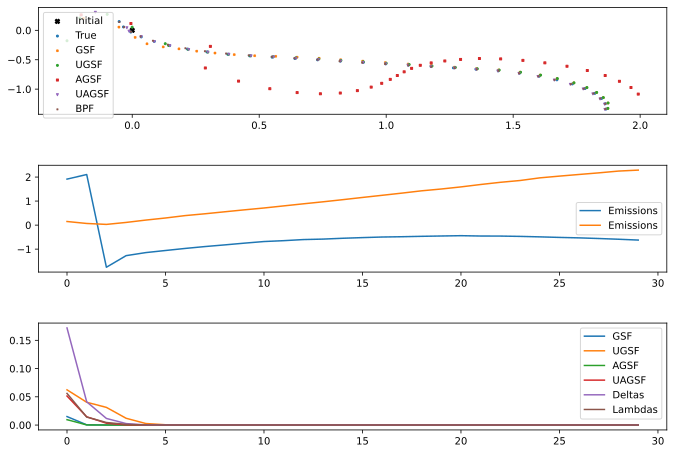

sim 64/100
key0:  [3757085292  912647599]
key:  [ 357705266 2563541628]
       Time taken for GSF:  0.9466123580932617
       Time taken for UGSF:  0.9890470504760742
       Time taken for AGSF:  6.6107988357543945
       Time taken for UAGSF:  7.061165809631348
       Time taken for BPF:  3.395270824432373
              GSF RMSE: 0.046540994
              UGSF RMSE: 0.05538143
              AGSF RMSE: 0.007999819
              UAGSF RMSE: 0.030704247
              BPF RMSE: 0.024928816


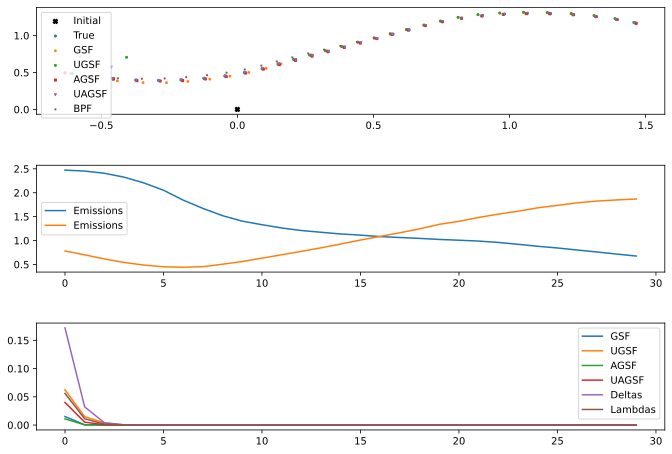

sim 65/100
key0:  [ 661572511 4218224004]
key:  [2791900570   26459955]
       Time taken for GSF:  0.8763298988342285
       Time taken for UGSF:  0.9814579486846924
       Time taken for AGSF:  6.549256801605225
       Time taken for UAGSF:  7.026366949081421
       Time taken for BPF:  3.3519961833953857
              GSF RMSE: 0.013159712
              UGSF RMSE: 0.019515578
              AGSF RMSE: 0.010900127
              UAGSF RMSE: 0.010220839
              BPF RMSE: 0.11857198


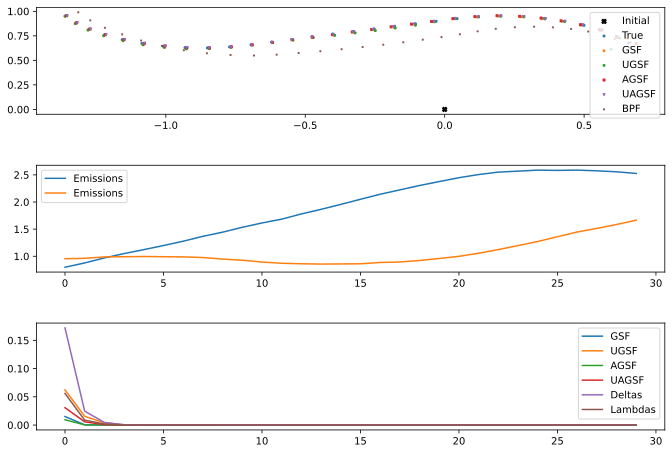

sim 66/100
key0:  [3427393284 2281600490]
key:  [2502352421  386484703]
       Time taken for GSF:  0.8710529804229736
       Time taken for UGSF:  3.804476022720337
       Time taken for AGSF:  6.637544870376587
       Time taken for UAGSF:  7.1105568408966064
       Time taken for BPF:  3.372260808944702
              GSF RMSE: 0.02631424
              UGSF RMSE: 0.02284889
              AGSF RMSE: 0.025338339
              UAGSF RMSE: 0.01161229
              BPF RMSE: 0.0073058903


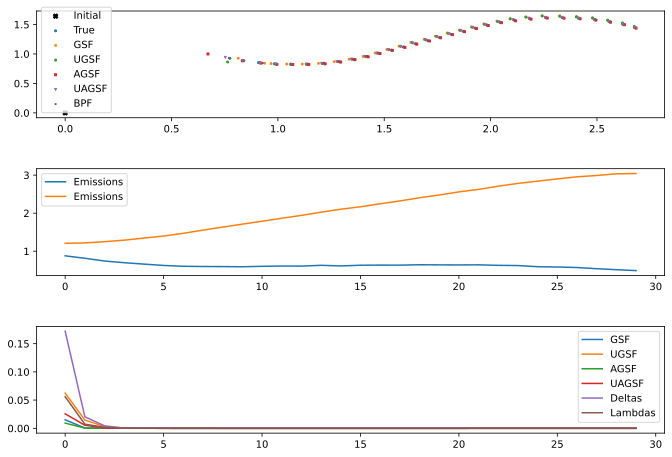

sim 67/100
key0:  [4216753897 3437139068]
key:  [2421089496  825359818]
       Time taken for GSF:  0.9365451335906982
       Time taken for UGSF:  0.9779529571533203
       Time taken for AGSF:  6.568413972854614
       Time taken for UAGSF:  6.985901832580566
       Time taken for BPF:  3.3724021911621094
              GSF RMSE: 0.011875516
              UGSF RMSE: 0.02550369
              AGSF RMSE: 0.01222638
              UAGSF RMSE: 0.015815798
              BPF RMSE: 0.0054218564


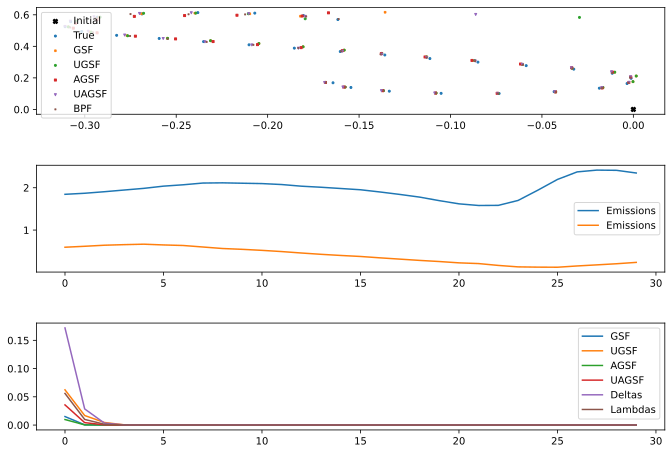

sim 68/100
key0:  [3766128474 2998578151]
key:  [4163432688 1204078184]
       Time taken for GSF:  0.8863110542297363
       Time taken for UGSF:  1.0161137580871582
       Time taken for AGSF:  6.646481037139893
       Time taken for UAGSF:  7.022438049316406
       Time taken for BPF:  3.430403709411621
              GSF RMSE: 0.014045671
              UGSF RMSE: 0.02099888
              AGSF RMSE: 0.009156492
              UAGSF RMSE: 0.0076678516
              BPF RMSE: 0.004769052


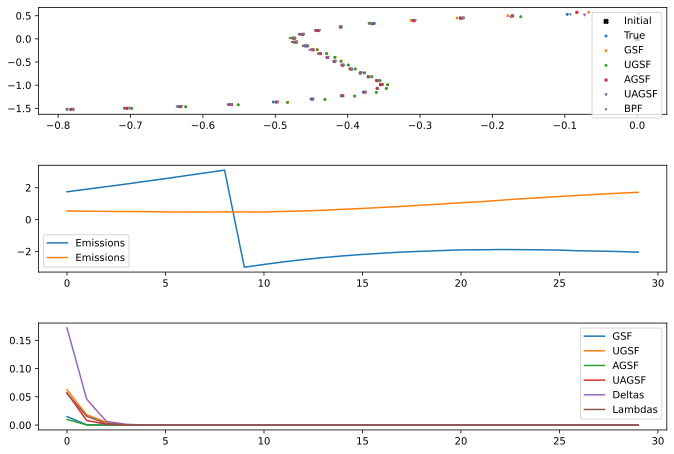

sim 69/100
key0:  [4128623668 4216911137]
key:  [2196032381  770221195]
       Time taken for GSF:  0.9001882076263428
       Time taken for UGSF:  1.032762050628662
       Time taken for AGSF:  9.649155855178833
       Time taken for UAGSF:  6.9829699993133545
       Time taken for BPF:  3.37603497505188
              GSF RMSE: 0.010412971
              UGSF RMSE: 0.01996601
              AGSF RMSE: 0.0089014815
              UAGSF RMSE: 0.013384856
              BPF RMSE: 0.0055766553


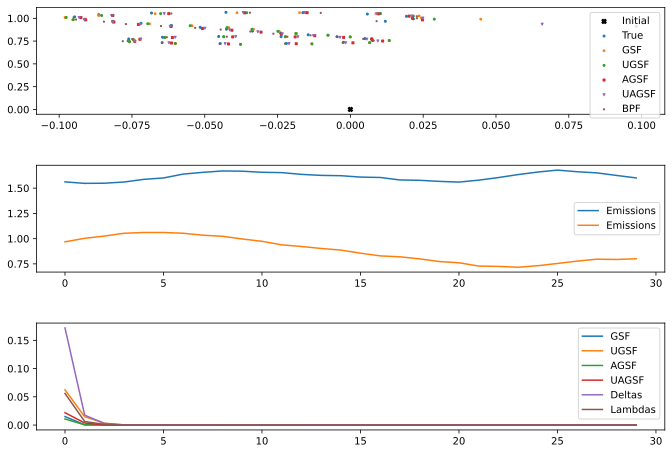

sim 70/100
key0:  [1766853340  992522559]
key:  [3901187291  205450875]
       Time taken for GSF:  0.90325927734375
       Time taken for UGSF:  1.0080609321594238
       Time taken for AGSF:  6.584172248840332
       Time taken for UAGSF:  6.972365140914917
       Time taken for BPF:  3.346011161804199
              GSF RMSE: 0.018433847
              UGSF RMSE: 0.025471406
              AGSF RMSE: 0.0251814
              UAGSF RMSE: 0.019732052
              BPF RMSE: 0.0065095094


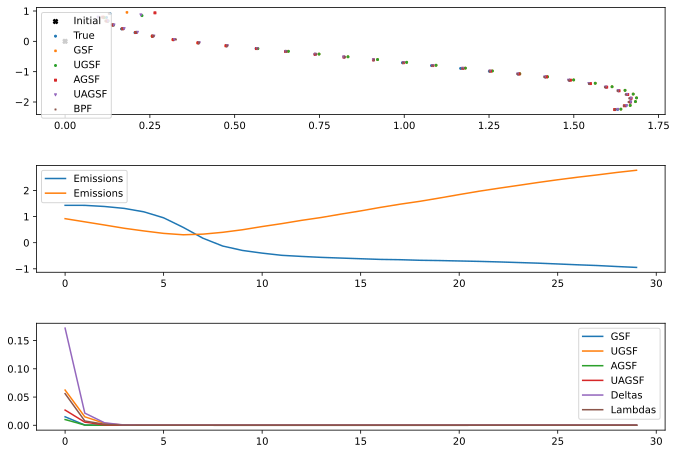

sim 71/100
key0:  [3642009555 1035709618]
key:  [1059844704 2282868745]
       Time taken for GSF:  0.9007689952850342
       Time taken for UGSF:  0.9831700325012207
       Time taken for AGSF:  6.615729808807373
       Time taken for UAGSF:  6.936040878295898
       Time taken for BPF:  3.4122719764709473
              GSF RMSE: 0.017019467
              UGSF RMSE: 0.02702551
              AGSF RMSE: 0.00529669
              UAGSF RMSE: 0.013174255
              BPF RMSE: 0.005134712


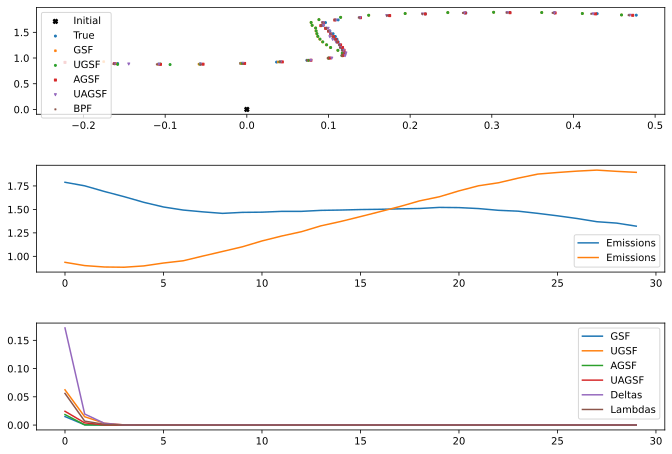

sim 72/100
key0:  [1068985975  103459135]
key:  [1720967730  244030160]
       Time taken for GSF:  0.9477241039276123
       Time taken for UGSF:  1.0068819522857666
       Time taken for AGSF:  9.665712118148804
       Time taken for UAGSF:  7.1062140464782715
       Time taken for BPF:  3.3972959518432617
              GSF RMSE: nan
              UGSF RMSE: 0.061335795
              AGSF RMSE: 1.5856984
              UAGSF RMSE: 0.019027015
              BPF RMSE: 0.08344131


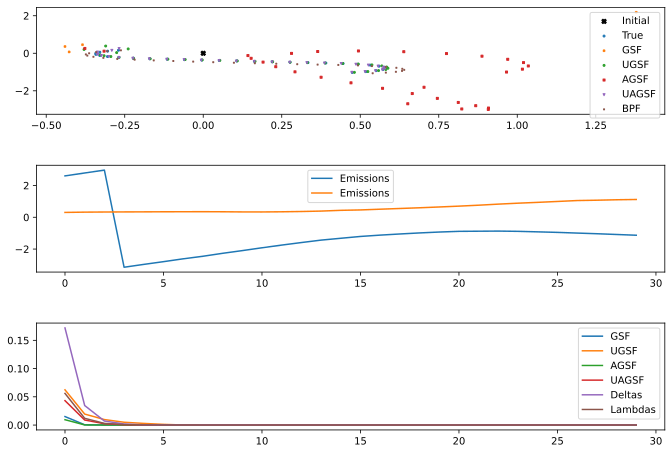

sim 73/100
key0:  [1029100688  852640707]
key:  [2559773278 2083926449]
       Time taken for GSF:  0.872197151184082
       Time taken for UGSF:  1.0420000553131104
       Time taken for AGSF:  6.693572759628296
       Time taken for UAGSF:  7.911562204360962
       Time taken for BPF:  3.479551076889038
              GSF RMSE: 0.009710746
              UGSF RMSE: 0.019762088
              AGSF RMSE: 0.010014474
              UAGSF RMSE: 0.012230882
              BPF RMSE: 0.0049028993


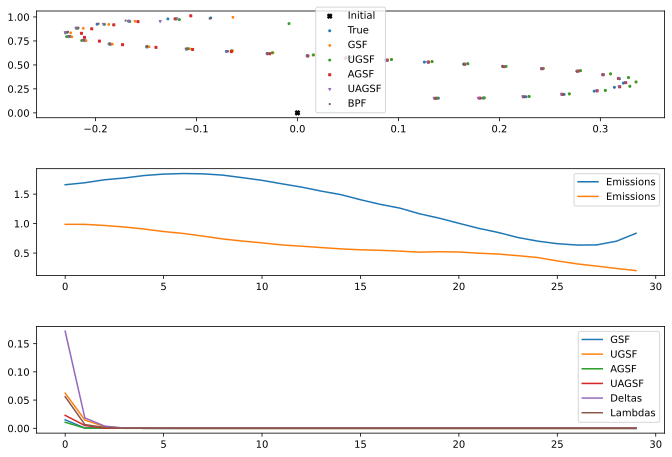

sim 74/100
key0:  [ 63750304 611340893]
key:  [ 130844233 4042254844]
       Time taken for GSF:  0.924386739730835
       Time taken for UGSF:  1.0071310997009277
       Time taken for AGSF:  6.62778902053833
       Time taken for UAGSF:  7.028200149536133
       Time taken for BPF:  3.3994407653808594
              GSF RMSE: nan
              UGSF RMSE: 0.030199988
              AGSF RMSE: 0.07171032
              UAGSF RMSE: 0.018149123
              BPF RMSE: 0.01720881


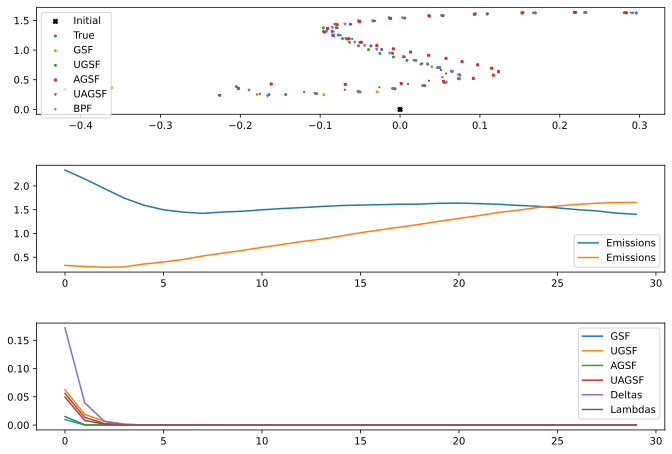

sim 75/100
key0:  [3098906929 2125285375]
key:  [1538347445 2998754256]
       Time taken for GSF:  0.9076449871063232
       Time taken for UGSF:  1.0244739055633545
       Time taken for AGSF:  6.717800140380859
       Time taken for UAGSF:  10.655415773391724
       Time taken for BPF:  3.4185221195220947
              GSF RMSE: 0.013526444
              UGSF RMSE: 0.0119779
              AGSF RMSE: 0.016126933
              UAGSF RMSE: 0.00893978
              BPF RMSE: 0.005206457


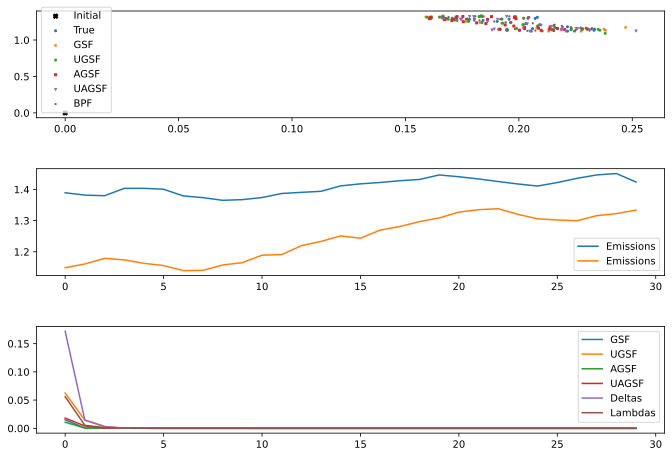

sim 76/100
key0:  [3304678098 2686878888]
key:  [3728752596 1018145908]
       Time taken for GSF:  0.9514322280883789
       Time taken for UGSF:  1.0323562622070312
       Time taken for AGSF:  6.632966756820679
       Time taken for UAGSF:  6.9539337158203125
       Time taken for BPF:  3.340291976928711
              GSF RMSE: 0.00896653
              UGSF RMSE: 0.012231142
              AGSF RMSE: 0.0077861603
              UAGSF RMSE: 0.01273123
              BPF RMSE: 0.008108698


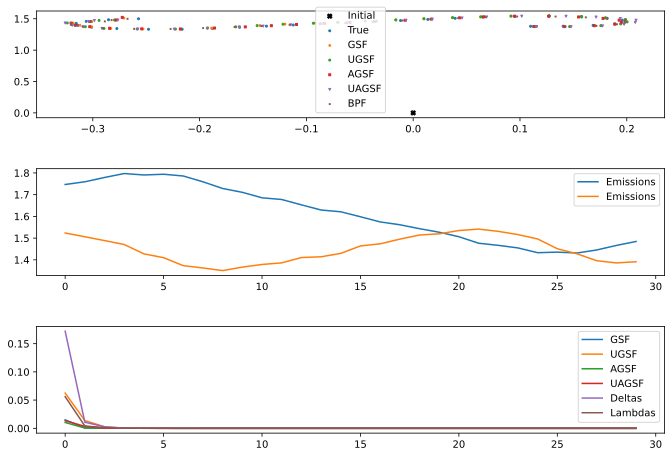

sim 77/100
key0:  [1904848050 1902556246]
key:  [1850405598 2831545586]
       Time taken for GSF:  0.9382970333099365
       Time taken for UGSF:  1.0726070404052734
       Time taken for AGSF:  6.71529221534729
       Time taken for UAGSF:  7.101434946060181
       Time taken for BPF:  3.3897221088409424
              GSF RMSE: 0.015663857
              UGSF RMSE: 0.025140986
              AGSF RMSE: 0.0061010537
              UAGSF RMSE: 0.015744893
              BPF RMSE: 0.011224149


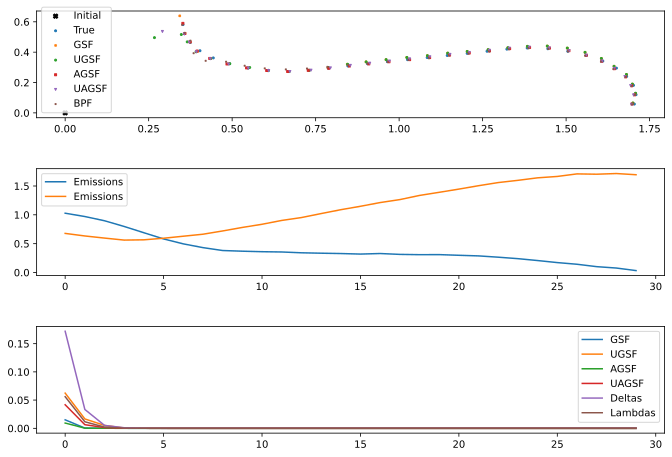

sim 78/100
key0:  [ 33622251 260603537]
key:  [2692549449 3502030742]
       Time taken for GSF:  0.8957760334014893
       Time taken for UGSF:  1.0095479488372803
       Time taken for AGSF:  6.715007066726685
       Time taken for UAGSF:  7.077978134155273
       Time taken for BPF:  3.350227117538452
              GSF RMSE: 0.015610709
              UGSF RMSE: 0.019810343
              AGSF RMSE: 0.010095116
              UAGSF RMSE: 0.01460093
              BPF RMSE: 0.0045700376


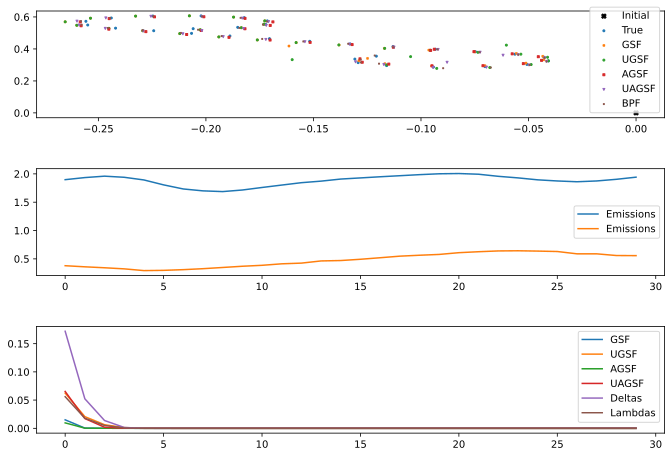

sim 79/100
key0:  [3550834898 3021684562]
key:  [ 169256403 1825228908]
       Time taken for GSF:  0.9625978469848633
       Time taken for UGSF:  0.9952058792114258
       Time taken for AGSF:  10.19699501991272
       Time taken for UAGSF:  7.1528401374816895
       Time taken for BPF:  3.322031021118164
              GSF RMSE: nan
              UGSF RMSE: nan
              AGSF RMSE: 2.4692557
              UAGSF RMSE: 2.2415488
              BPF RMSE: 0.51110935


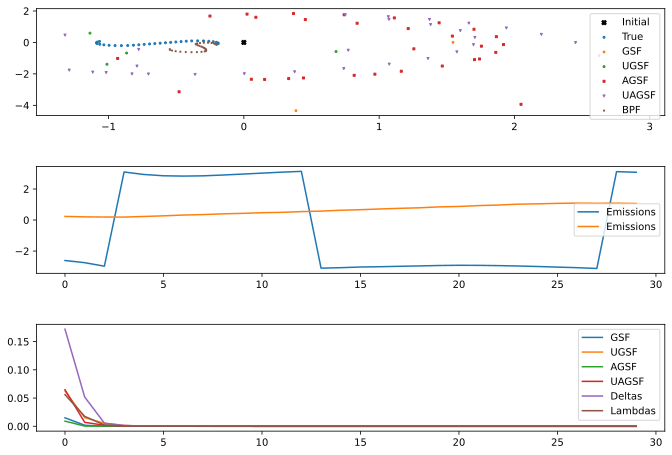

sim 80/100
key0:  [2453036040  750301776]
key:  [1727409852 1122385035]
       Time taken for GSF:  0.9488620758056641
       Time taken for UGSF:  1.0355408191680908
       Time taken for AGSF:  6.627662658691406
       Time taken for UAGSF:  6.992400169372559
       Time taken for BPF:  3.437296152114868
              GSF RMSE: 0.012021681
              UGSF RMSE: 0.025248768
              AGSF RMSE: 0.011464523
              UAGSF RMSE: 0.013350232
              BPF RMSE: 0.0041697263


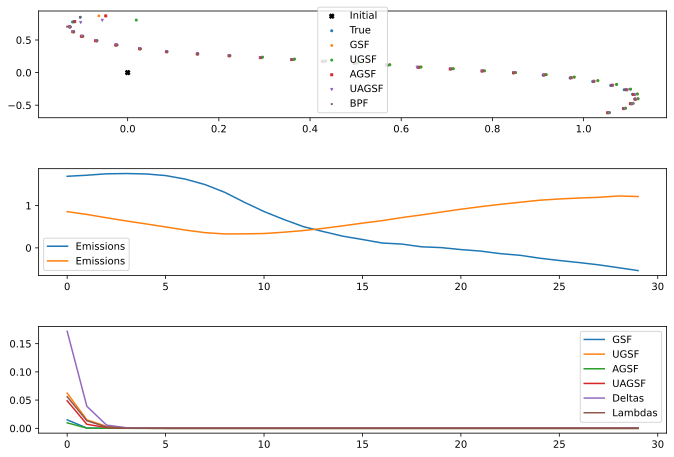

sim 81/100
key0:  [2224467380 2650892616]
key:  [3840433784  223133259]
       Time taken for GSF:  0.9059591293334961
       Time taken for UGSF:  1.036694049835205
       Time taken for AGSF:  6.700617074966431
       Time taken for UAGSF:  6.940632104873657
       Time taken for BPF:  3.429353952407837
              GSF RMSE: 0.05072963
              UGSF RMSE: 0.040241458
              AGSF RMSE: 0.024877626
              UAGSF RMSE: 0.032634564
              BPF RMSE: 0.004566396


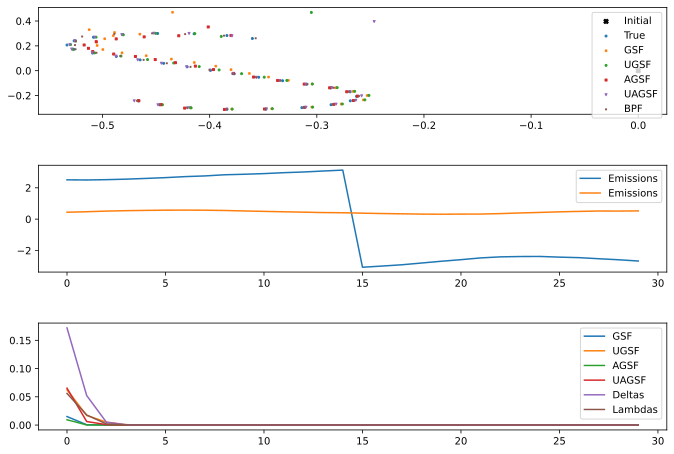

sim 82/100
key0:  [2267320037 2939307473]
key:  [ 995903540 3579019335]
       Time taken for GSF:  0.931204080581665
       Time taken for UGSF:  1.0059118270874023
       Time taken for AGSF:  6.711609840393066
       Time taken for UAGSF:  6.951225757598877
       Time taken for BPF:  3.3363699913024902
              GSF RMSE: 0.018167987
              UGSF RMSE: 0.018144673
              AGSF RMSE: 0.0070742005
              UAGSF RMSE: 0.0063179694
              BPF RMSE: 0.033580758


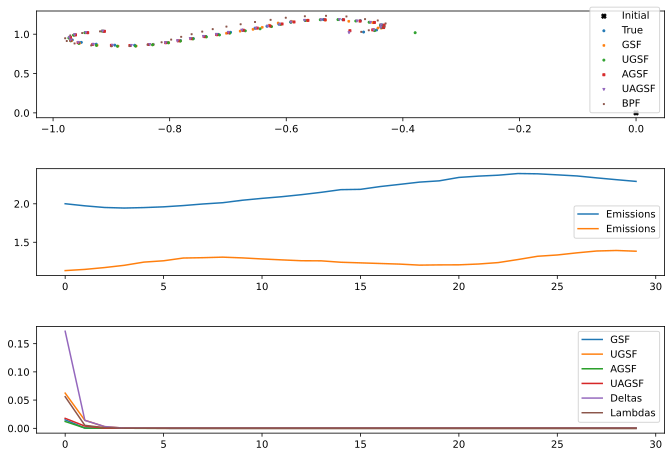

sim 83/100
key0:  [1315200527 2241917959]
key:  [4134790228 3193602026]
       Time taken for GSF:  0.8970041275024414
       Time taken for UGSF:  0.9893150329589844
       Time taken for AGSF:  10.309427976608276
       Time taken for UAGSF:  7.117868185043335
       Time taken for BPF:  3.3357131481170654
              GSF RMSE: 0.014450392
              UGSF RMSE: 0.025923586
              AGSF RMSE: 0.025156744
              UAGSF RMSE: 0.029474167
              BPF RMSE: 0.20302145


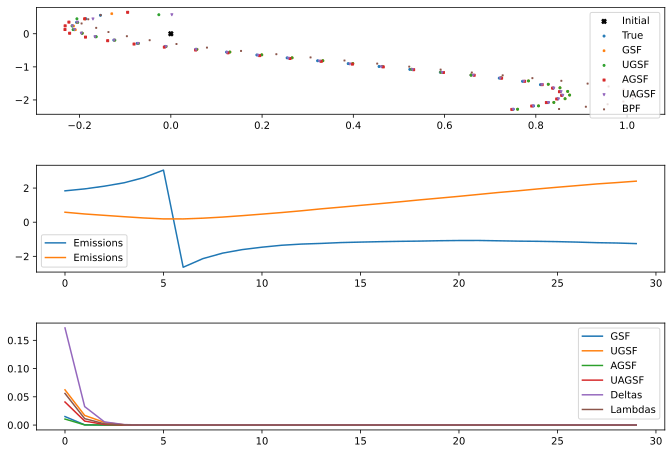

sim 84/100
key0:  [3270624867 3525800659]
key:  [3403489312  420238825]
       Time taken for GSF:  1.0236318111419678
       Time taken for UGSF:  1.5853919982910156
       Time taken for AGSF:  6.752331018447876
       Time taken for UAGSF:  7.022566080093384
       Time taken for BPF:  3.383636951446533
              GSF RMSE: 0.01565772
              UGSF RMSE: 0.03233474
              AGSF RMSE: 0.013321809
              UAGSF RMSE: 0.012329884
              BPF RMSE: 0.0057851626


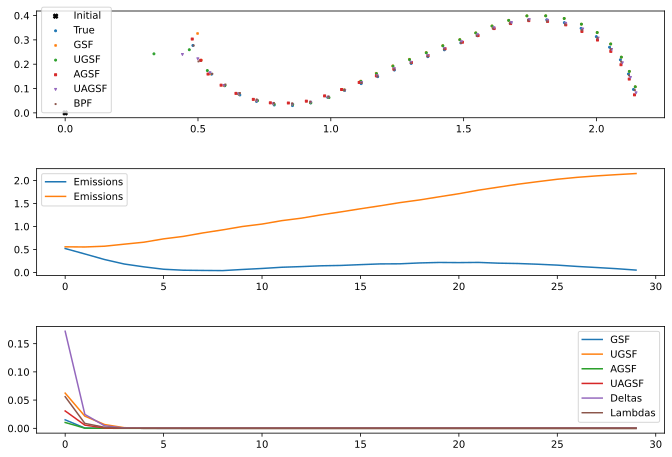

sim 85/100
key0:  [3527989559  201165388]
key:  [3319928876 2413533594]
       Time taken for GSF:  0.9395599365234375
       Time taken for UGSF:  1.0171749591827393
       Time taken for AGSF:  6.688931941986084
       Time taken for UAGSF:  6.957212924957275
       Time taken for BPF:  3.384086847305298
              GSF RMSE: 0.016832585
              UGSF RMSE: 0.025676517
              AGSF RMSE: 0.027389819
              UAGSF RMSE: 0.014148666
              BPF RMSE: 0.005066764


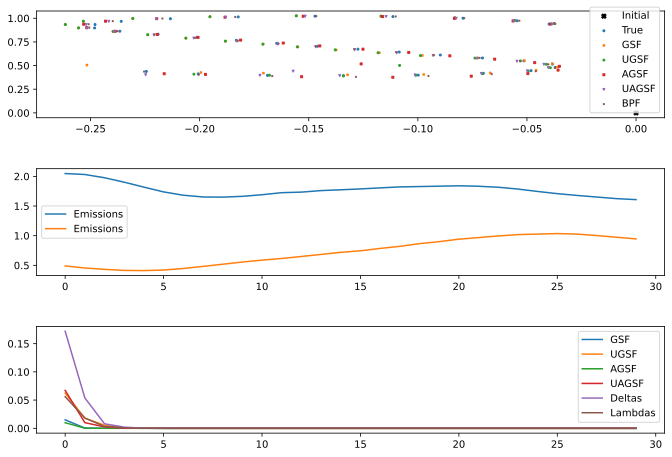

sim 86/100
key0:  [1738606094 3027727165]
key:  [2130493535 3202182244]
       Time taken for GSF:  0.9360039234161377
       Time taken for UGSF:  1.000427007675171
       Time taken for AGSF:  6.772630929946899
       Time taken for UAGSF:  7.003784894943237
       Time taken for BPF:  3.423161029815674
              GSF RMSE: 0.020713342
              UGSF RMSE: 0.024720741
              AGSF RMSE: 0.022344211
              UAGSF RMSE: 0.011921101
              BPF RMSE: 0.09818518


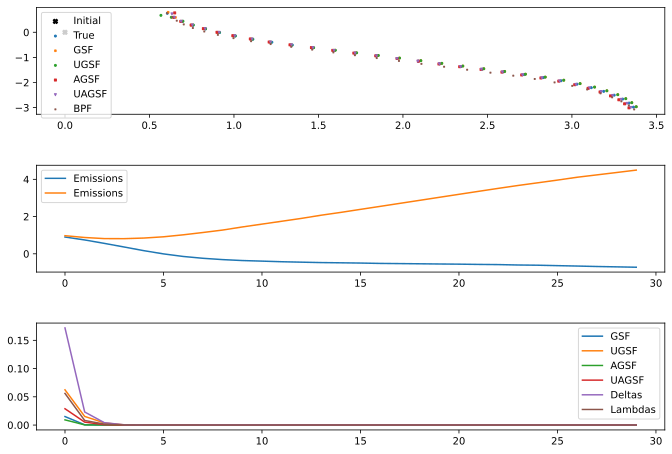

sim 87/100
key0:  [1270597363 4020158462]
key:  [ 975468785 2130504651]
       Time taken for GSF:  4.796365976333618
       Time taken for UGSF:  1.0312719345092773
       Time taken for AGSF:  6.67203688621521
       Time taken for UAGSF:  7.04046630859375
       Time taken for BPF:  3.4372611045837402
              GSF RMSE: 0.014715257
              UGSF RMSE: 0.02232546
              AGSF RMSE: 0.007434863
              UAGSF RMSE: 0.03616947
              BPF RMSE: 0.006056181


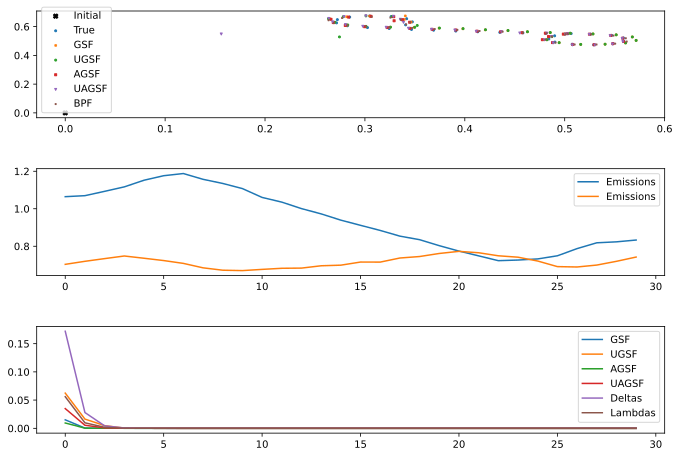

sim 88/100
key0:  [1890969210 1886189240]
key:  [3737732968  541797692]
       Time taken for GSF:  0.9393846988677979
       Time taken for UGSF:  1.055804967880249
       Time taken for AGSF:  6.843084812164307
       Time taken for UAGSF:  7.153250694274902
       Time taken for BPF:  3.4398279190063477
              GSF RMSE: 0.015221115
              UGSF RMSE: 0.011835283
              AGSF RMSE: 0.024990316
              UAGSF RMSE: 0.011347106
              BPF RMSE: 0.009424137


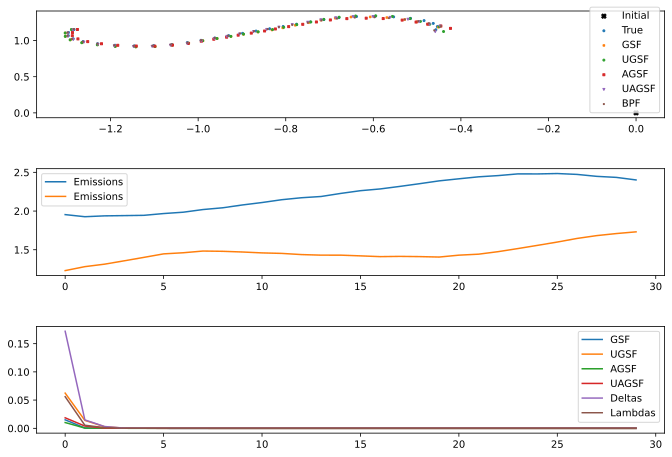

sim 89/100
key0:  [1930838959 3571013835]
key:  [3380473150 1842813300]
       Time taken for GSF:  0.9551169872283936
       Time taken for UGSF:  1.0357582569122314
       Time taken for AGSF:  6.654317855834961
       Time taken for UAGSF:  7.096678018569946
       Time taken for BPF:  3.371500015258789
              GSF RMSE: 0.015288644
              UGSF RMSE: 0.031356703
              AGSF RMSE: 0.01575054
              UAGSF RMSE: 0.017125657
              BPF RMSE: 0.0048512053


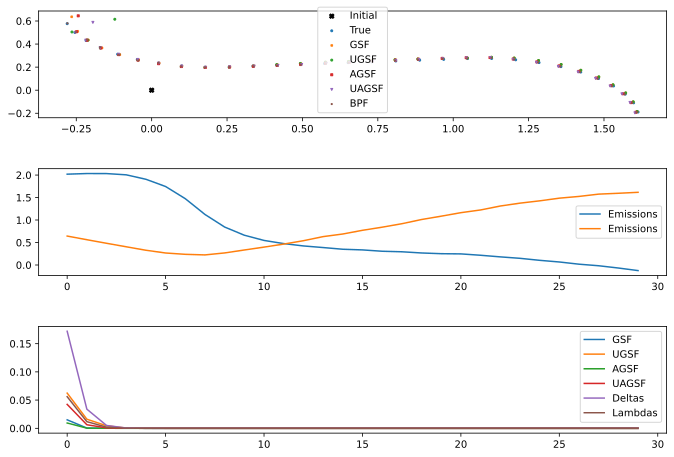

sim 90/100
key0:  [2408631316 4109196784]
key:  [3203281602 1891528791]
       Time taken for GSF:  0.9052848815917969
       Time taken for UGSF:  1.0396249294281006
       Time taken for AGSF:  6.693245887756348
       Time taken for UAGSF:  6.752140998840332
       Time taken for BPF:  3.3705010414123535
              GSF RMSE: 0.015997427
              UGSF RMSE: 0.018562697
              AGSF RMSE: 0.010939976
              UAGSF RMSE: 0.021830227
              BPF RMSE: 0.004511672


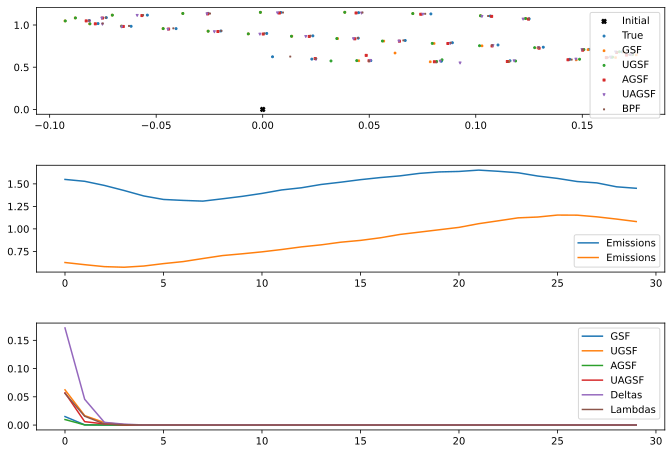

sim 91/100
key0:  [4109227876  335414910]
key:  [4160417025  928684538]
       Time taken for GSF:  0.9286880493164062
       Time taken for UGSF:  4.968177080154419
       Time taken for AGSF:  6.715025901794434
       Time taken for UAGSF:  7.132304906845093
       Time taken for BPF:  3.420780897140503
              GSF RMSE: 0.022385655
              UGSF RMSE: 0.025167754
              AGSF RMSE: 0.019655697
              UAGSF RMSE: 0.018508064
              BPF RMSE: 0.018203406


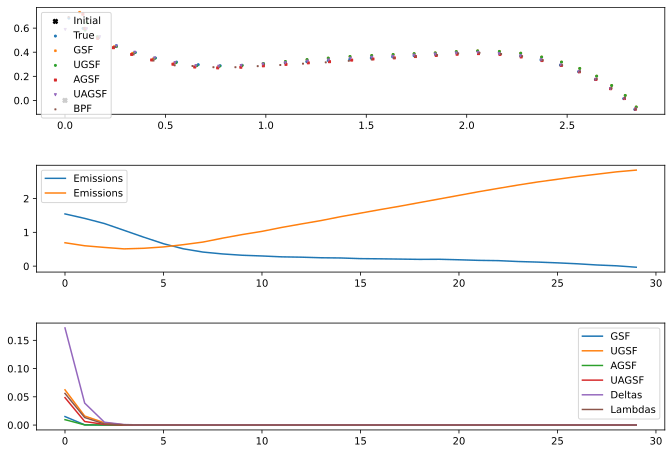

sim 92/100
key0:  [3624893526 2777656520]
key:  [3249949232 2315826805]
       Time taken for GSF:  0.9510200023651123
       Time taken for UGSF:  1.0662338733673096
       Time taken for AGSF:  9.058630228042603
       Time taken for UAGSF:  7.040013790130615
       Time taken for BPF:  3.4360508918762207
              GSF RMSE: 0.019032825
              UGSF RMSE: 0.022649735
              AGSF RMSE: 0.019803287
              UAGSF RMSE: 0.011595454
              BPF RMSE: 0.004681836


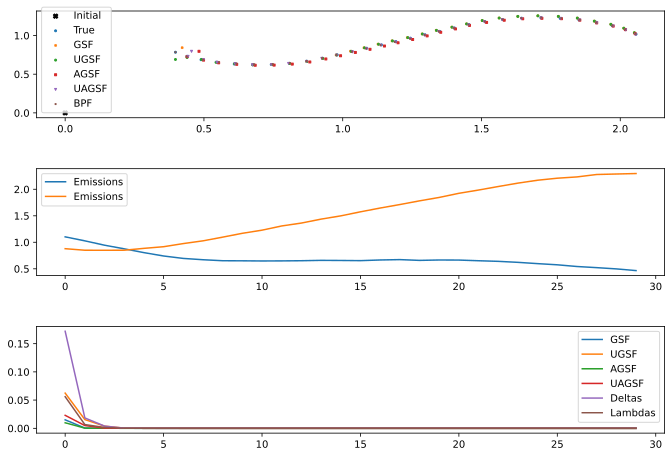

sim 93/100
key0:  [1076503109 3998189389]
key:  [3131066673 1828241873]
       Time taken for GSF:  1.2901611328125
       Time taken for UGSF:  1.042452096939087
       Time taken for AGSF:  8.645715951919556
       Time taken for UAGSF:  8.16691517829895
       Time taken for BPF:  3.4141252040863037
              GSF RMSE: 0.014216067
              UGSF RMSE: 0.029100813
              AGSF RMSE: 0.010311955
              UAGSF RMSE: 0.022932863
              BPF RMSE: 0.004477522


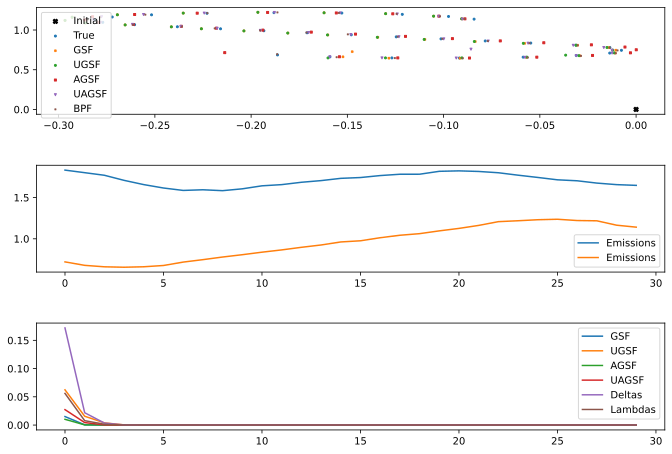

sim 94/100
key0:  [3093408068 1121192653]
key:  [4157461403 2339088927]
       Time taken for GSF:  0.871873140335083
       Time taken for UGSF:  0.9470860958099365
       Time taken for AGSF:  6.441671848297119
       Time taken for UAGSF:  6.624693870544434
       Time taken for BPF:  3.4325039386749268
              GSF RMSE: 0.013348839
              UGSF RMSE: 0.01424002
              AGSF RMSE: 0.007021872
              UAGSF RMSE: 0.007560741
              BPF RMSE: 0.009337842


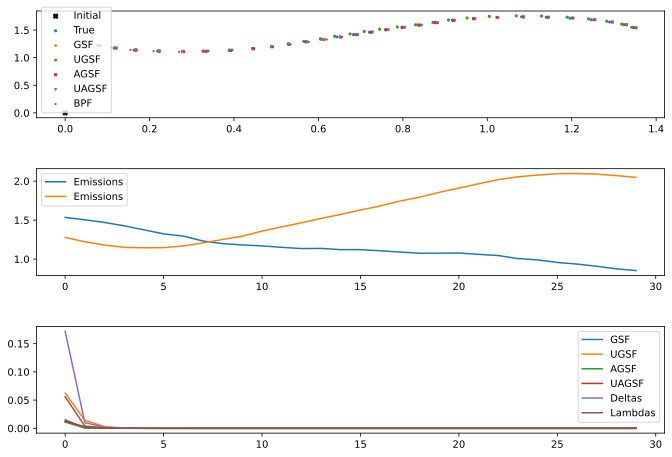

sim 95/100
key0:  [2368165947 3767300836]
key:  [494107837 847257214]
       Time taken for GSF:  0.8653340339660645
       Time taken for UGSF:  0.9764950275421143
       Time taken for AGSF:  10.520874977111816
       Time taken for UAGSF:  1010.3430728912354
       Time taken for BPF:  3.2896173000335693
              GSF RMSE: 0.0120313335
              UGSF RMSE: 0.027184773
              AGSF RMSE: 0.016628219
              UAGSF RMSE: 0.028584117
              BPF RMSE: 0.0070713027


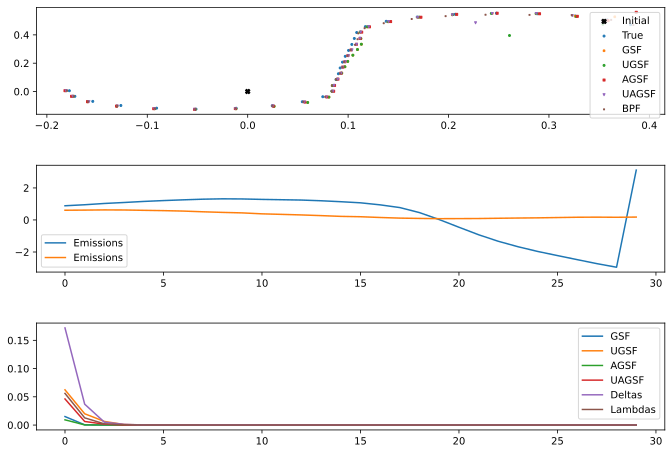

sim 96/100
key0:  [1724406739 1751605629]
key:  [3386218830 3594907482]
       Time taken for GSF:  0.8927090167999268
       Time taken for UGSF:  0.9636192321777344
       Time taken for AGSF:  6.499346971511841
       Time taken for UAGSF:  6.901605129241943
       Time taken for BPF:  3.3262100219726562
              GSF RMSE: 0.019061202
              UGSF RMSE: 0.023675185
              AGSF RMSE: 0.023568818
              UAGSF RMSE: 0.0072149783
              BPF RMSE: 0.00591995


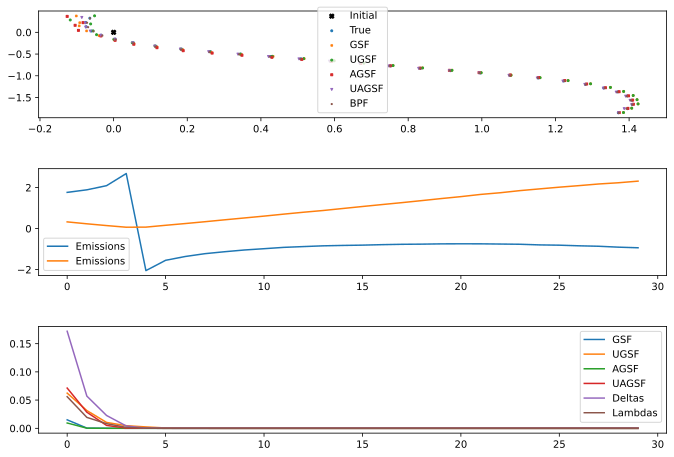

sim 97/100
key0:  [209844117 932810560]
key:  [4069255975 3434966514]
       Time taken for GSF:  0.8552267551422119
       Time taken for UGSF:  0.8984498977661133
       Time taken for AGSF:  6.208921194076538
       Time taken for UAGSF:  6.4048662185668945
       Time taken for BPF:  3.3576412200927734
              GSF RMSE: 0.01684145
              UGSF RMSE: 0.018874705
              AGSF RMSE: 0.014943762
              UAGSF RMSE: 0.0072184624
              BPF RMSE: 0.0066052545


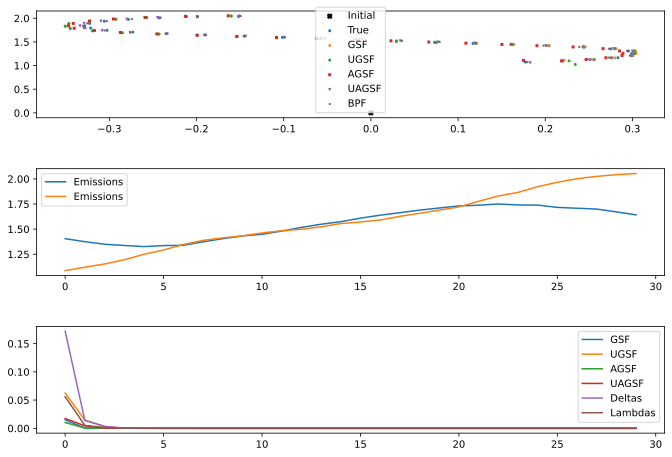

sim 98/100
key0:  [1971833268 3810184210]
key:  [ 842754151 3463081024]
       Time taken for GSF:  0.8593049049377441
       Time taken for UGSF:  0.9208948612213135
       Time taken for AGSF:  6.356443881988525
       Time taken for UAGSF:  6.524461030960083
       Time taken for BPF:  951.8654823303223
              GSF RMSE: 0.020582616
              UGSF RMSE: 0.03213747
              AGSF RMSE: 0.015423484
              UAGSF RMSE: 0.011047413
              BPF RMSE: 0.006710742


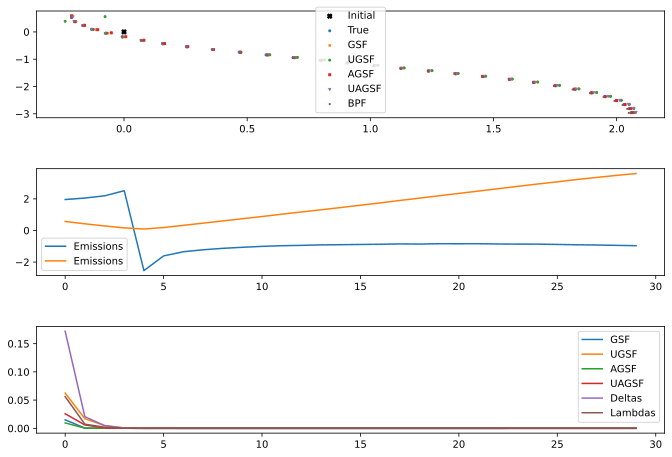

sim 99/100
key0:  [1951263449 2520687282]
key:  [1824873217 1349310974]
       Time taken for GSF:  0.8715457916259766
       Time taken for UGSF:  0.9698717594146729
       Time taken for AGSF:  6.350696086883545
       Time taken for UAGSF:  10.743933916091919
       Time taken for BPF:  3.3107731342315674
              GSF RMSE: 0.01225102
              UGSF RMSE: 0.028790673
              AGSF RMSE: 0.011413921
              UAGSF RMSE: 0.026841726
              BPF RMSE: 0.0036559976


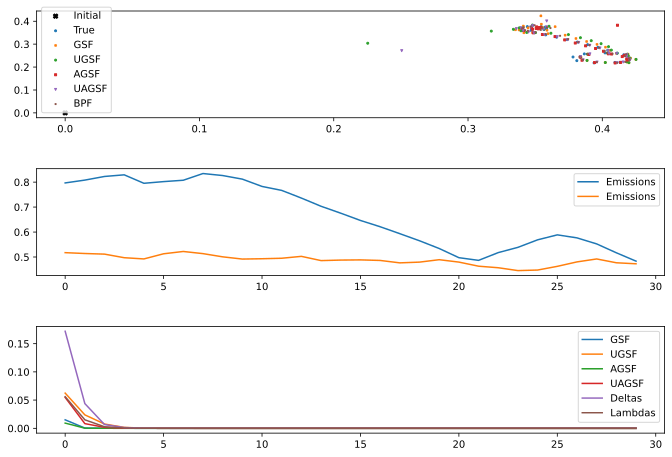

sim 100/100
key0:  [2815106496 4119242553]
key:  [3871773583 2752233313]
       Time taken for GSF:  1.3021938800811768
       Time taken for UGSF:  1.0813782215118408
       Time taken for AGSF:  6.547305107116699
       Time taken for UAGSF:  6.452811002731323
       Time taken for BPF:  3.2954859733581543
              GSF RMSE: 0.013958382
              UGSF RMSE: 0.026544886
              AGSF RMSE: 0.019209862
              UAGSF RMSE: 0.02878856
              BPF RMSE: 0.0060753804


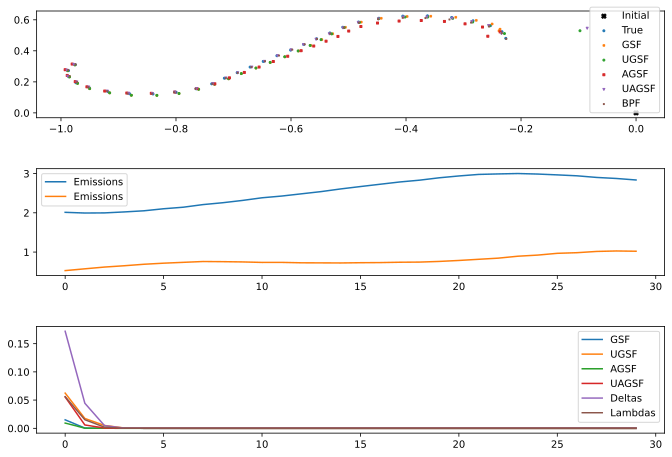

In [5]:
verbose = False
Nsim = 100
gsf_rmse = jnp.zeros(Nsim)
ugsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
uagsf_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)

gsf_norm = jnp.zeros((Nsim, seq_length))
ugsf_norm = jnp.zeros((Nsim, seq_length))
agsf_norm = jnp.zeros((Nsim, seq_length))
uagsf_norm = jnp.zeros((Nsim, seq_length))
bpf_norm = jnp.zeros((Nsim, seq_length))

gsf_time = jnp.zeros(Nsim)
ugsf_time = jnp.zeros(Nsim)
agsf_time = jnp.zeros(Nsim)
uagsf_time = jnp.zeros(Nsim)
bpf_time = jnp.zeros(Nsim)
next_key = jr.PRNGKey(1)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key0, key, next_key = jr.split(next_key, 3)
    print('key0: ', key0)
    print('key: ', key)
    states, emissions = model.sample(params, key0, seq_length, inputs = inputs)

    # GSF
    M = 2
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    t_gsf= tout - tin
    print('       Time taken for GSF: ', tout - tin)

    # U-GSF
    tin = time.time()
    uparams = ParamsUKF(1,0,0)
    posterior_filtered_ugsf = gf.unscented_gaussian_sum_filter(params, uparams, emissions, M, 1, inputs)
    point_estimate_ugsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_ugsf.means, posterior_filtered_ugsf.weights), axis=0)
    tout = time.time()
    t_ugsf= tout - tin
    print('       Time taken for UGSF: ', tout - tin)

    # AGSF
    opt_args = (0.8, 0.5)
    num_components = [M, num_prt1, num_prt2]
    tin = time.time()
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    t_agsf= tout - tin
    print('       Time taken for AGSF: ', tout - tin)

    # U-AGSF
    tin = time.time()
    posterior_filtered_uagsf, aux_outputs = gf.unscented_agsf(params, uparams, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)
    point_estimate_uagsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_uagsf.means, posterior_filtered_uagsf.weights), axis=0)
    tout = time.time()
    t_uagsf= tout - tin
    print('       Time taken for UAGSF: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 800000

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=q0,
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=r0,
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs, 1.0)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    t_bpf = tout - tin
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_rmse = gsf_rmse.at[i].set(utils.rmse(point_estimate_gsf[:, (0,2)], states[:, (0,2)]))
    ugsf_rmse = ugsf_rmse.at[i].set(utils.rmse(point_estimate_ugsf[:, (0,2)], states[:, (0,2)]))
    agsf_rmse = agsf_rmse.at[i].set(utils.rmse(point_estimate_agsf[:, (0,2)], states[:, (0,2)]))
    uagsf_rmse = uagsf_rmse.at[i].set(utils.rmse(point_estimate_uagsf[:, (0,2)], states[:, (0,2)]))
    bpf_rmse = bpf_rmse.at[i].set(utils.rmse(point_estimate_bpf[:, (0,2)], states[:, (0,2)]))

    print('              GSF RMSE:', gsf_rmse[i])                                                                           
    print('              UGSF RMSE:', ugsf_rmse[i])
    print('              AGSF RMSE:', agsf_rmse[i])
    print('              UAGSF RMSE:', uagsf_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])

    gsf_norm = gsf_norm.at[i].set(jnp.linalg.norm(point_estimate_gsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    ugsf_norm = ugsf_norm.at[i].set(jnp.linalg.norm(point_estimate_ugsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    agsf_norm = agsf_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    uagsf_norm = uagsf_norm.at[i].set(jnp.linalg.norm(point_estimate_uagsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    bpf_norm = bpf_norm.at[i].set(jnp.linalg.norm(point_estimate_bpf[:,(0,2)] - states[:,(0,2)], axis = 1))

    gsf_time = gsf_time.at[i].set(t_gsf)
    ugsf_time = ugsf_time.at[i].set(t_ugsf)
    agsf_time = agsf_time.at[i].set(t_agsf)
    uagsf_time = uagsf_time.at[i].set(t_uagsf)
    bpf_time = bpf_time.at[i].set(t_bpf)

    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
    axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
    axes[0].scatter(point_estimate_ugsf[:,0], point_estimate_ugsf[:,2], label = 'UGSF', s = 4, marker = 'o')
    axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
    axes[0].scatter(point_estimate_uagsf[:,0], point_estimate_uagsf[:,2], label = 'UAGSF', s = 4, marker = 'v')
    axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
    axes[0].legend()   

    axes[1].plot(emissions, label = 'Emissions')
    axes[1].legend()

    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_ugsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'UGSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_agsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'AGSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_uagsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'UAGSF')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
    axes[2].legend()

 

    plt.show()

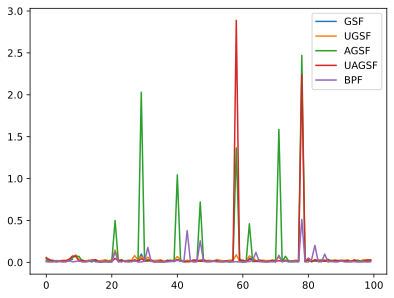

In [6]:
plt.plot(gsf_rmse, label = 'GSF')
plt.plot(ugsf_rmse, label = 'UGSF')
plt.plot(agsf_rmse, label = 'AGSF')
plt.plot(uagsf_rmse, label = 'UAGSF')
plt.plot(bpf_rmse, label = 'BPF')
plt.legend()
plt.show()

In [7]:
jnp.std(uagsf_time[uagsf_time<100])

Array(0.7537984, dtype=float32)

In [8]:
import pandas as pd
def bootstrap(key, rmse_array, B):
    N = rmse_array.shape[0]
    rmse_boot = jnp.zeros((B,))
    for b in range(B):
        key, subkey = jr.split(key)
        ind = jr.randint(subkey, (N,), 0, N)
        rmse_boot = rmse_boot.at[b].set(jnp.mean(rmse_array[ind]))
    return rmse_boot

keys = jr.split(jr.PRNGKey(0), 5)
B = 100
gsf_boot = bootstrap(keys[0], gsf_rmse, B)
ugsf_boot = bootstrap(keys[1], ugsf_rmse, B)
agsf_boot = bootstrap(keys[2], agsf_rmse, B)
uagsf_boot = bootstrap(keys[3], uagsf_rmse, B)
bpf_boot = bootstrap(keys[4], bpf_rmse, B)


gsf_armse = jnp.mean(gsf_boot)
ugsf_armse = jnp.mean(ugsf_boot)
agsf_armse = jnp.mean(agsf_boot)
uagsf_armse = jnp.mean(uagsf_boot)
bpf_armse = jnp.mean(bpf_boot)

# gsf_armse = jnp.mean(gsf_rmse)
# ugsf_armse = jnp.mean(ugsf_rmse)
# agsf_armse = jnp.mean(agsf_rmse)
# uagsf_armse = jnp.mean(uagsf_rmse)
# bpf_armse = jnp.mean(bpf_rmse)

gsf_atime = jnp.mean(gsf_time)
ugsf_atime = jnp.mean(ugsf_time)
agsf_atime = jnp.mean(agsf_time)
uagsf_atime = jnp.mean(uagsf_time)
bpf_atime = jnp.mean(bpf_time)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_boot))
ugsf_tab_out = '{:10.2f}±{:10.2f}'.format(ugsf_armse, jnp.std(ugsf_boot))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_boot))
uagsf_tab_out = '{:10.2f}±{:10.2f}'.format(uagsf_armse, jnp.std(uagsf_boot))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_boot))

gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, jnp.std(gsf_time))
ugsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(ugsf_atime, jnp.std(ugsf_time))
agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, jnp.std(agsf_time))
uagsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(uagsf_atime, jnp.std(uagsf_time))
bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, jnp.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
# df[' '] = ['GSF', 'AGSF', 'AGSF Optimal', 'BPF']
# df['RMSE'] = [gsf_tab_out, agsf_tab_out, agsf_opt_tab_out, bpf_tab_out]
# df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, agsf_opt_tab_out1, bpf_tab_out1]
df[' '] = ['GSF','UGSF', 'AGSF', 'UAGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, ugsf_tab_out, agsf_tab_out, uagsf_tab_out, bpf_tab_out]
df['time(s)'] = [gsf_tab_out1, ugsf_tab_out1, agsf_tab_out1, uagsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))
df

\begin{tabular}{lll}
\toprule
  & RMSE & time(s) \\
\midrule
GSF &        nan±       nan &       0.99±      0.45 \\
UGSF &        nan±       nan &       1.10±      0.56 \\
AGSF &       0.12±      0.04 &       7.00±      0.89 \\
UAGSF &       0.07±      0.03 &      17.28±     99.81 \\
BPF &       0.03±      0.01 &      12.88±     94.37 \\
\bottomrule
\end{tabular}



RMSE                time(s)
0    GSF         nan±       nan        0.99±      0.45
1   UGSF         nan±       nan        1.10±      0.56
2   AGSF        0.12±      0.04        7.00±      0.89
3  UAGSF        0.07±      0.03       17.28±     99.81
4    BPF        0.03±      0.01       12.88±     94.37